In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import spacy

목표 : 리뷰 데이터를 바탕으로, 딥러닝 모델을 기획하여 회사 인사이트를 뽑아낼 수 있는 것을 목표로 함.

50회 이상의 리뷰를 쓴 고객님의 경우, 단골 고객님으로 판정할 수 있음.(약 250명)
평점 예측 자체는 무의미하다고 판단함.
5점을 준 고객님의 경우, 제품이나 서비스에 대해서 만족을 해서 주는 경우도 있지만, 크게 의미 없이 5점을 주는 경우도 있다고 생각함. 후자의 경우, 그냥 크게 문제가 없었더라면 5점을 주는 경우가 있기 때문. 이 경우 우리가 추출할 수 있는 인사이트는 제한적이라고 판단됨.

반면에, 5점이 아닌 4점 이하의 경우, 상대적으로 5점을 준 고객님들에 비해 그 이하의 점수를 준 이유가 분명한 경우가 많을 것이라 판단함.
예를 들자면, 맛이 괜찮은데 서비스가 별로여서 3~4점을 주는 경우도 있고, 맛이 별로여서 1~2점을 줄 수도 있기 때문에 우리 회사의 제품이나 서비스에 대한 추출할 수 있는 인사이트가 많을 것으로 예상됨.

모델링을 진행해보고자 하는 것 : 머신러닝(랜덤포레스트 or boosting 모델), LSTM, Transformer을 활용해볼 것.

재구매율이 낮은 고객님한테서 가장 많이 나오는 단어가 핵심적이라 판단함.


일반적으로 고객님들이 설문지를 통해 평점을 기록할 때, 고객님이 아닌 회사가 만든 정형화된 틀이다보니 고객님의 불편사항이나 니즈가 회사로 전달되는데 어느 정도 한계가 있을 것이라 판단함. 그렇기 때문에 텍스트를 작성하는 것이 상대적으로 고객님의 니즈가 반영된 목소리라고 판단되며, 텍스트 모델링이 그만큼 앞으로 중요해질 것이라 판단함.

이러한 분석을 하게 된 배경은 일반적으로 우리가 식당에 갔을 때, 가게 사장님께서 음식은 괜찮았냐라는 질문을 하셨을 때, 맛이 없었더라도 맛있었다고 하는 경우가 많다. 이처럼, 리뷰 작성에 있어서도 평점에서 5점을 받는 경우, 진짜 만족을 해서 5점을 주는 경우도 있지만 크게 의미 없이 5점을 주는 경우도 있다. 그렇다면 의미 없이 5점을 주는 것에 회사에서는 우리 제품이나 서비스가 5점을 받았으니 문제가 없구나라고만 그냥 받아들여야 하는가? 에서 시작하게 되었다. 만약에 5점을 주었는데도 불구하고, 해당 서비스를 지속적으로 이용하지 않는 경우 진정 만족한 점수라고 판단할 수 없다고 생각하였다. 그렇다면 그냥 의미 없이 주는 5점에 초점을 맞추는 것이 아니라 5점을 주지 않는 고객들, 서비스를 재이용하지 않는 고객님들의 목소리를 귀기울여야 하지 않을까라는 생각을 하였다. 세분화된 고객의 니즈이기 때문에 모든 목소리에 귀를 기울일 수 없지만, 어느 정도 공통적인 의견의 경우, 이는 비즈니스 운영에서 우리가 개선을 해야되는 요소이다. 이를 리뷰를 통해 나타내는 경우가 많을텐데, 텍스트 모델링을 통해 서비스 재이용이 이루어지지않는 고객님의 텍스트 모델링을 통해 어떠한 공통적인 요소가 나타나는지를 파악하고자 해당 분석을 시작하게 되었다. 

# 1.EDA 진행

In [ ]:
df = pd.read_csv('Reviews.csv')
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [ ]:
df['UserId'].value_counts()

A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A1KFVEDDNABPJA      1
A18IQMKLGKT1JJ      1
A18KO44YXO2BP7      1
A3FX71BV0L80AB      1
A3SOIHQ5XBSR4D      1
Name: UserId, Length: 256059, dtype: int64

In [ ]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [ ]:
a = pd.DataFrame(df['UserId'].value_counts())
a = a.reset_index()
user_count = a.rename(columns = {'index' : 'UserId', 'UserId': 'number'})

In [ ]:
user_count

,UserId,number
0,A3OXHLG6DIBRW8,448
1,A1YUL9PCJR3JTY,421
2,AY12DBB0U420B,389
3,A281NPSIMI1C2R,365
4,A1Z54EM24Y40LL,256
...,...,...
256054,A1KFVEDDNABPJA,1
256055,A18IQMKLGKT1JJ,1
256056,A18KO44YXO2BP7,1
256057,A3FX71BV0L80AB,1


In [ ]:
df = pd.merge(df, user_count, how = 'inner', on = 'UserId')
df1 = df
df1

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,number
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,3
3,320691,B000CQ26E0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,4,1187740800,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ...",3
4,468954,B004DMGQKE,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,5,1351209600,Awesome service and great products,We sent this product as a gift to my husband's...,3
...,...,...,...,...,...,...,...,...,...,...,...
568449,568445,B001EO7N10,A2SD7TY3IOX69B,"BayBay ""BayBay Knows Best""",3,3,5,1245369600,Best Value for Chinese 5 Spice,"As a foodie, I use a lot of Chinese 5 Spice po...",1
568450,568447,B001EO7N10,A2P9W8T7NTLG2Z,Andy,0,0,2,1328918400,Mixed wrong,I had ordered some of these a few months back ...,1
568451,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,1
568452,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1


In [ ]:
lists = []

for i in range(len(user_count)):
    if user_count['number'][i] > 5 :
        lists.append(user_count.loc[i])
    else :
        continue
        
    
    

In [ ]:
user_count5 = pd.DataFrame(lists)
user_count5

,UserId,number
0,A3OXHLG6DIBRW8,448
1,A1YUL9PCJR3JTY,421
2,AY12DBB0U420B,389
3,A281NPSIMI1C2R,365
4,A1Z54EM24Y40LL,256
...,...,...
18171,A25AIQ0NF6TUJ5,6
18172,A3S9QVVBFGJS1B,6
18173,A3FZA2HOBWKT54,6
18174,A2DU57HN759EW9,6


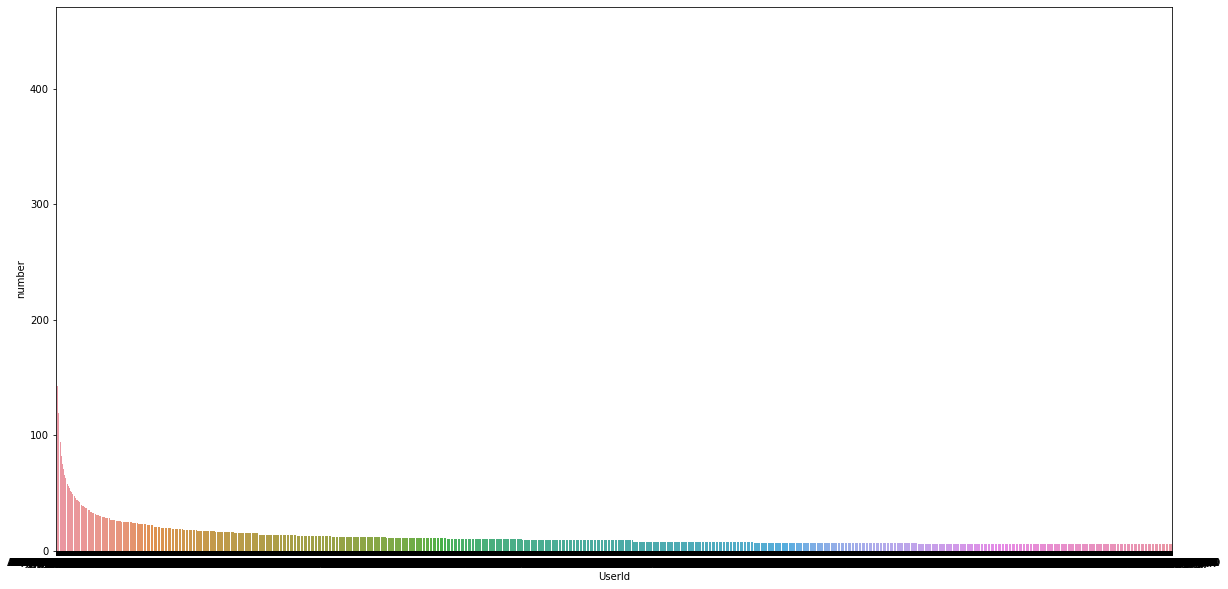

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x = 'UserId', y = 'number', data = user_count5)

In [ ]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text', 'number'],
      dtype='object')

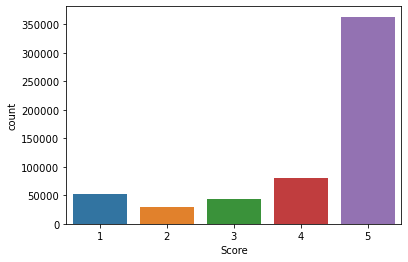

In [ ]:
sns.countplot(x = 'Score', data = df)

In [ ]:
df2 = df1

df3 = pd.merge(df2, user_count5, how = 'inner', on = 'UserId')

In [ ]:
df3.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName                0
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   25
Text                       0
number_x                   0
number_y                   0
dtype: int64

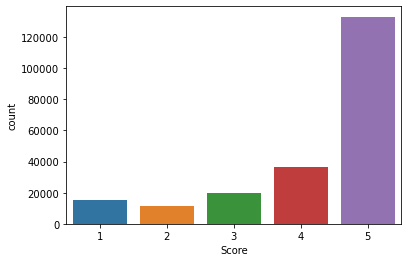

In [ ]:
sns.countplot(x = 'Score', data = df3)

## 비율을 보자면 5점이 가장 많은 것으로 확인됨. 이후에, 5점은 1, 4점 이하는 0으로 이진 분류 진행할 예정
## 이진 분류로 하는 이유는 5점이 아닌 점수는 그만큼 어느정도 만족하지 못한 부분이 있으니까 주는 점수라고 판단되었기 때문에 우리가 
## 인사이트를 뽑아낼 수 있는 의견이 반영되어 있을 것이라 판단하였음.

In [ ]:
df4 = []
for i in range(len(df3)):
    if df3['Score'][i] == 5 :
        df4.append(df3.loc[i])
    else :
        continue
        

In [ ]:
df4 = pd.DataFrame(df4)

In [ ]:
df4['UserId'].value_counts()

A281NPSIMI1C2R    326
AY12DBB0U420B     286
A3OXHLG6DIBRW8    271
A1YUL9PCJR3JTY    240
A1TMAVN4CEM8U8    182
                 ... 
A3NNOTZUB56O04      1
A3JGXC99P2U2RI      1
AIFLY2HF8NS8U       1
APX38OL5RONWA       1
AWWQ4SBK1VKQ9       1
Name: UserId, Length: 15512, dtype: int64

In [ ]:
df2['UserId'].value_counts()

A3OXHLG6DIBRW8    448
A1YUL9PCJR3JTY    421
AY12DBB0U420B     389
A281NPSIMI1C2R    365
A1Z54EM24Y40LL    256
                 ... 
A1KFVEDDNABPJA      1
A18IQMKLGKT1JJ      1
A18KO44YXO2BP7      1
A3FX71BV0L80AB      1
A3SOIHQ5XBSR4D      1
Name: UserId, Length: 256059, dtype: int64

In [ ]:
df3

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,number_x,number_y
0,12,B0009XLVG0,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",4,4,5,1282867200,"My cats LOVE this ""diet"" food better than thei...",One of my boys needed to lose some weight and ...,12,12
1,3938,B001L1KH6Y,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",3,3,5,1232323200,LOVE this coffee. Packs a wallop in the morning.,If I drank more than one commuter cup in the m...,12,12
2,135729,B003THML30,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",0,0,5,1285718400,Awesomely delicious!,"Love Cliff bars, but have only liked the Peanu...",12,12
3,271541,B004YWHTBS,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",0,0,5,1285718400,Awesomely delicious!,"Love Cliff bars, but have only liked the Peanu...",12,12
4,295757,B003WLC4VC,A2725IB4YY9JEB,"A Poeng ""SparkyGoHome""",0,0,5,1285718400,Awesomely delicious!,"Love Cliff bars, but have only liked the Peanu...",12,12
...,...,...,...,...,...,...,...,...,...,...,...,...
216817,464696,B000UBD88A,A3S85G23DOG5MB,"Jo Stanley ""Coffee Lover""",0,0,5,1242172800,Senseo is sensational,The best coffee product at the best price with...,6,6
216818,464759,B000UBD88A,A3S85G23DOG5MB,"Jo Stanley ""Coffee Lover""",0,0,5,1198886400,Yummy Coffee,Senseo coffee is delicious - rates right up al...,6,6
216819,488313,B0013A0QXC,A3S85G23DOG5MB,"Jo Stanley ""Coffee Lover""",0,0,5,1257033600,Senseo Dark Roast,This is what coffee is all about! Full flavor...,6,6
216820,488336,B0013A0QXC,A3S85G23DOG5MB,"Jo Stanley ""Coffee Lover""",0,0,5,1242172800,Senseo is sensational,The best coffee product at the best price with...,6,6


In [ ]:
df3.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text',
       'number_x', 'number_y'],
      dtype='object')

In [ ]:
df['ProfileName'].value_counts()

C. F. Hill "CFH"                          451
O. Brown "Ms. O. Khannah-Brown"           421
Gary Peterson                             389
Rebecca of Amazon "The Rebecca Review"    365
Chris                                     363
                                         ... 
Chefjdcm                                    1
Tamzin                                      1
Deep Thinker                                1
S. Drew                                     1
Kerrie Maydew                               1
Name: ProfileName, Length: 218416, dtype: int64

In [ ]:
df['ProductId'].value_counts()

B007JFMH8M    913
B0026RQTGE    632
B002QWP8H0    632
B002QWP89S    632
B002QWHJOU    632
             ... 
B0064KQWDO      1
B0001AGND2      1
B0028PDEBW      1
B005ATI8U0      1
B000LVM51U      1
Name: ProductId, Length: 74258, dtype: int64

In [ ]:
df['HelpfulnessNumerator'].value_counts()

0      303826
1      116467
2       53727
3       29007
4       16963
        ...  
126         1
231         1
233         1
153         1
491         1
Name: HelpfulnessNumerator, Length: 231, dtype: int64

In [ ]:
df['Time']

0         1303862400
1         1346976000
2         1219017600
3         1187740800
4         1351209600
             ...    
568449    1245369600
568450    1328918400
568451    1299628800
568452    1329782400
568453    1338422400
Name: Time, Length: 568454, dtype: int64

In [ ]:
df.shape, df1.shape, df2.shape, df3.shape

((568454, 11), (568454, 11), (568454, 11), (216822, 12))

In [ ]:
import re

regex = r"[^a-zA-Z0-9 ]"
subst = ""

def tokenize(text):
    """text 문자열을 의미있는 단어 단위로 list에 저장합니다.
    Args:
        text (str): 토큰화 할 문자열
    Returns:
        list: 토큰이 저장된 리스트
    """
    # 정규식 적용
    tokens = re.sub(regex, subst, text)

    # 소문자로 치환
    tokens = tokens.lower().split()
    
    return tokens

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import spacy


nlp = spacy.load("en_core_web_sm")

In [ ]:
!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_sm

In [ ]:
# def tokenize(document):
    
#     doc = nlp(document)
#     # punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
#     return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.is_alpha == True)]

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import TruncatedSVD
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
import scipy.stats as stats

# rfc = RandomForestClassifier()

# svd = TruncatedSVD(algorithm='randomized'
#                    , n_iter=5
#                    , random_state=2)

# pipe = Pipeline([
#     ('vect', vect),
#     ('svd', svd),
#     ('clf', rfc)
# ])

# pipe

In [ ]:
# parameters = {
# #     'vect__max_df': (0.7, 1.0) # document frequency(%) 높을 경우 제거
# #     ,'vect__min_df': (2, 5, 10) # document frequency(횟수) 낮을 경우 제거
# #     ,'vect__max_features': (5000, 20000) # 코퍼스에서 term frequency 높은 순서대로 나열하여 제한
#     'clf__n_estimators': (50, 100) # The number of trees in the forest.
#     ,'clf__max_depth': (10, 20, None) # The maximum depth of the tree
# }



# params = {
#     # 100~500 사이의 정수 크기로 차원을 줄입니다
# #     'svd__n_components': stats.randint(100, 500)
#     'svd__n_components': stats.randint(2, 3) # 문서의 차원을 2로 고정
    
# }

# random_search = RandomizedSearchCV(pipe,params, cv=3, n_iter=2, n_jobs=-1, verbose=1)
# random_search.fit(dtm, df3['Score'])

In [ ]:
# random_search.best_params_

In [ ]:
# random_search.best_score_

In [ ]:
df

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,number
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,3
3,320691,B000CQ26E0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,4,1187740800,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ...",3
4,468954,B004DMGQKE,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",0,0,5,1351209600,Awesome service and great products,We sent this product as a gift to my husband's...,3
...,...,...,...,...,...,...,...,...,...,...,...
568449,568445,B001EO7N10,A2SD7TY3IOX69B,"BayBay ""BayBay Knows Best""",3,3,5,1245369600,Best Value for Chinese 5 Spice,"As a foodie, I use a lot of Chinese 5 Spice po...",1
568450,568447,B001EO7N10,A2P9W8T7NTLG2Z,Andy,0,0,2,1328918400,Mixed wrong,I had ordered some of these a few months back ...,1
568451,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...,1
568452,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1


In [ ]:
--------------------------------정리중---------------------------------------

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
max_features = 20000

maxlen = 100
batch_size = 64



In [ ]:
df = df[['ProductId', 'UserId', 'Score', 'Summary','Text', 'number']]
df

,ProductId,UserId,Score,Summary,Text,number
0,B001E4KFG0,A3SGXH7AUHU8GW,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1
1,B00813GRG4,A1D87F6ZCVE5NK,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1
2,B000LQOCH0,ABXLMWJIXXAIN,4,"""Delight"" says it all",This is a confection that has been around a fe...,3
3,B000CQ26E0,ABXLMWJIXXAIN,4,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ...",3
4,B004DMGQKE,ABXLMWJIXXAIN,5,Awesome service and great products,We sent this product as a gift to my husband's...,3
...,...,...,...,...,...,...
568449,B001EO7N10,A2SD7TY3IOX69B,5,Best Value for Chinese 5 Spice,"As a foodie, I use a lot of Chinese 5 Spice po...",1
568450,B001EO7N10,A2P9W8T7NTLG2Z,2,Mixed wrong,I had ordered some of these a few months back ...,1
568451,B001EO7N10,A28KG5XORO54AY,5,Will not do without,Great for sesame chicken..this is a good if no...,1
568452,B004I613EE,A121AA1GQV751Z,5,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o...",1


In [ ]:
pro= pd.DataFrame(df['ProductId'].value_counts())

In [ ]:
pro = pro[pro['ProductId'] > 20]

## 데이터가 너무 크기 때문에 리뷰수가 20개 밑인 제품들은 상대적으로 의미가 적을 것이라 판단하여 drop하여 진행함.

In [ ]:
pro

,ProductId
B007JFMH8M,913
B0026RQTGE,632
B002QWP8H0,632
B002QWP89S,632
B002QWHJOU,632
...,...
B000W5BS9K,21
B0001IOSDQ,21
B000MXEN7Q,21
B0047YYSSA,21


In [ ]:
df['ProductId'].value_counts()

B007JFMH8M    913
B0026RQTGE    632
B002QWP8H0    632
B002QWP89S    632
B002QWHJOU    632
             ... 
B0064KQWDO      1
B0001AGND2      1
B0028PDEBW      1
B005ATI8U0      1
B000LVM51U      1
Name: ProductId, Length: 74258, dtype: int64

In [ ]:
pro = pro.reset_index()
pro

,index,ProductId
0,B007JFMH8M,913
1,B0026RQTGE,632
2,B002QWP8H0,632
3,B002QWP89S,632
4,B002QWHJOU,632
...,...,...
4770,B000W5BS9K,21
4771,B0001IOSDQ,21
4772,B000MXEN7Q,21
4773,B0047YYSSA,21


In [ ]:
pro = pro.rename(columns = {'index':'ProductId', 'ProductId' : 'count'})

In [ ]:
df = pd.merge(df, pro, how = 'inner', on = 'ProductId')

In [ ]:
df.columns

Index(['ProductId', 'UserId', 'Score', 'Summary', 'Text', 'number', 'count'], dtype='object')

In [ ]:
df = df.rename(columns = {'number':'repurchase', 'count': 'product_number'})

In [ ]:
df

,ProductId,UserId,Score,Summary,Text,repurchase,product_number
0,B000CQ26E0,ABXLMWJIXXAIN,4,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ...",3,21
1,B000CQ26E0,A2RNYW2HIQBGSM,5,"Tastes great, easy to make",These are really good. You do need to add jus...,46,21
2,B000CQ26E0,AZAKCIFE27RAA,5,My Teens Favorite!,Have been buying this for 2 years. My son and ...,18,21
3,B000CQ26E0,A2H8OLTO0I2F6J,4,One of my travel essentials,"For constant work travel, one of my packed mea...",18,21
4,B000CQ26E0,A32RWGJEWFUAB,4,My 8-year-old can't live without this,Annie's Mac & Cheese is my youngest son's favo...,4,21
...,...,...,...,...,...,...,...
331806,B001OZ5FPA,A1ZDPPIKGHN6WD,5,Good choice,Was one of the less expensive bonzai trees I c...,1,22
331807,B001OZ5FPA,A3NE1IR0KAMB1H,1,"incomplete order, refused refund",I ordered 3 plants from this company a year ag...,1,22
331808,B001OZ5FPA,ADBN8RAGDGG3R,5,My First Bonsai plant...,This is my first bonsai plant. I was wondering...,1,22
331809,B001OZ5FPA,A3M2FA3FZ20LYG,5,Doing business with 9greenbox,I did not receive the Bonsai Juniper Tree Zen ...,1,22


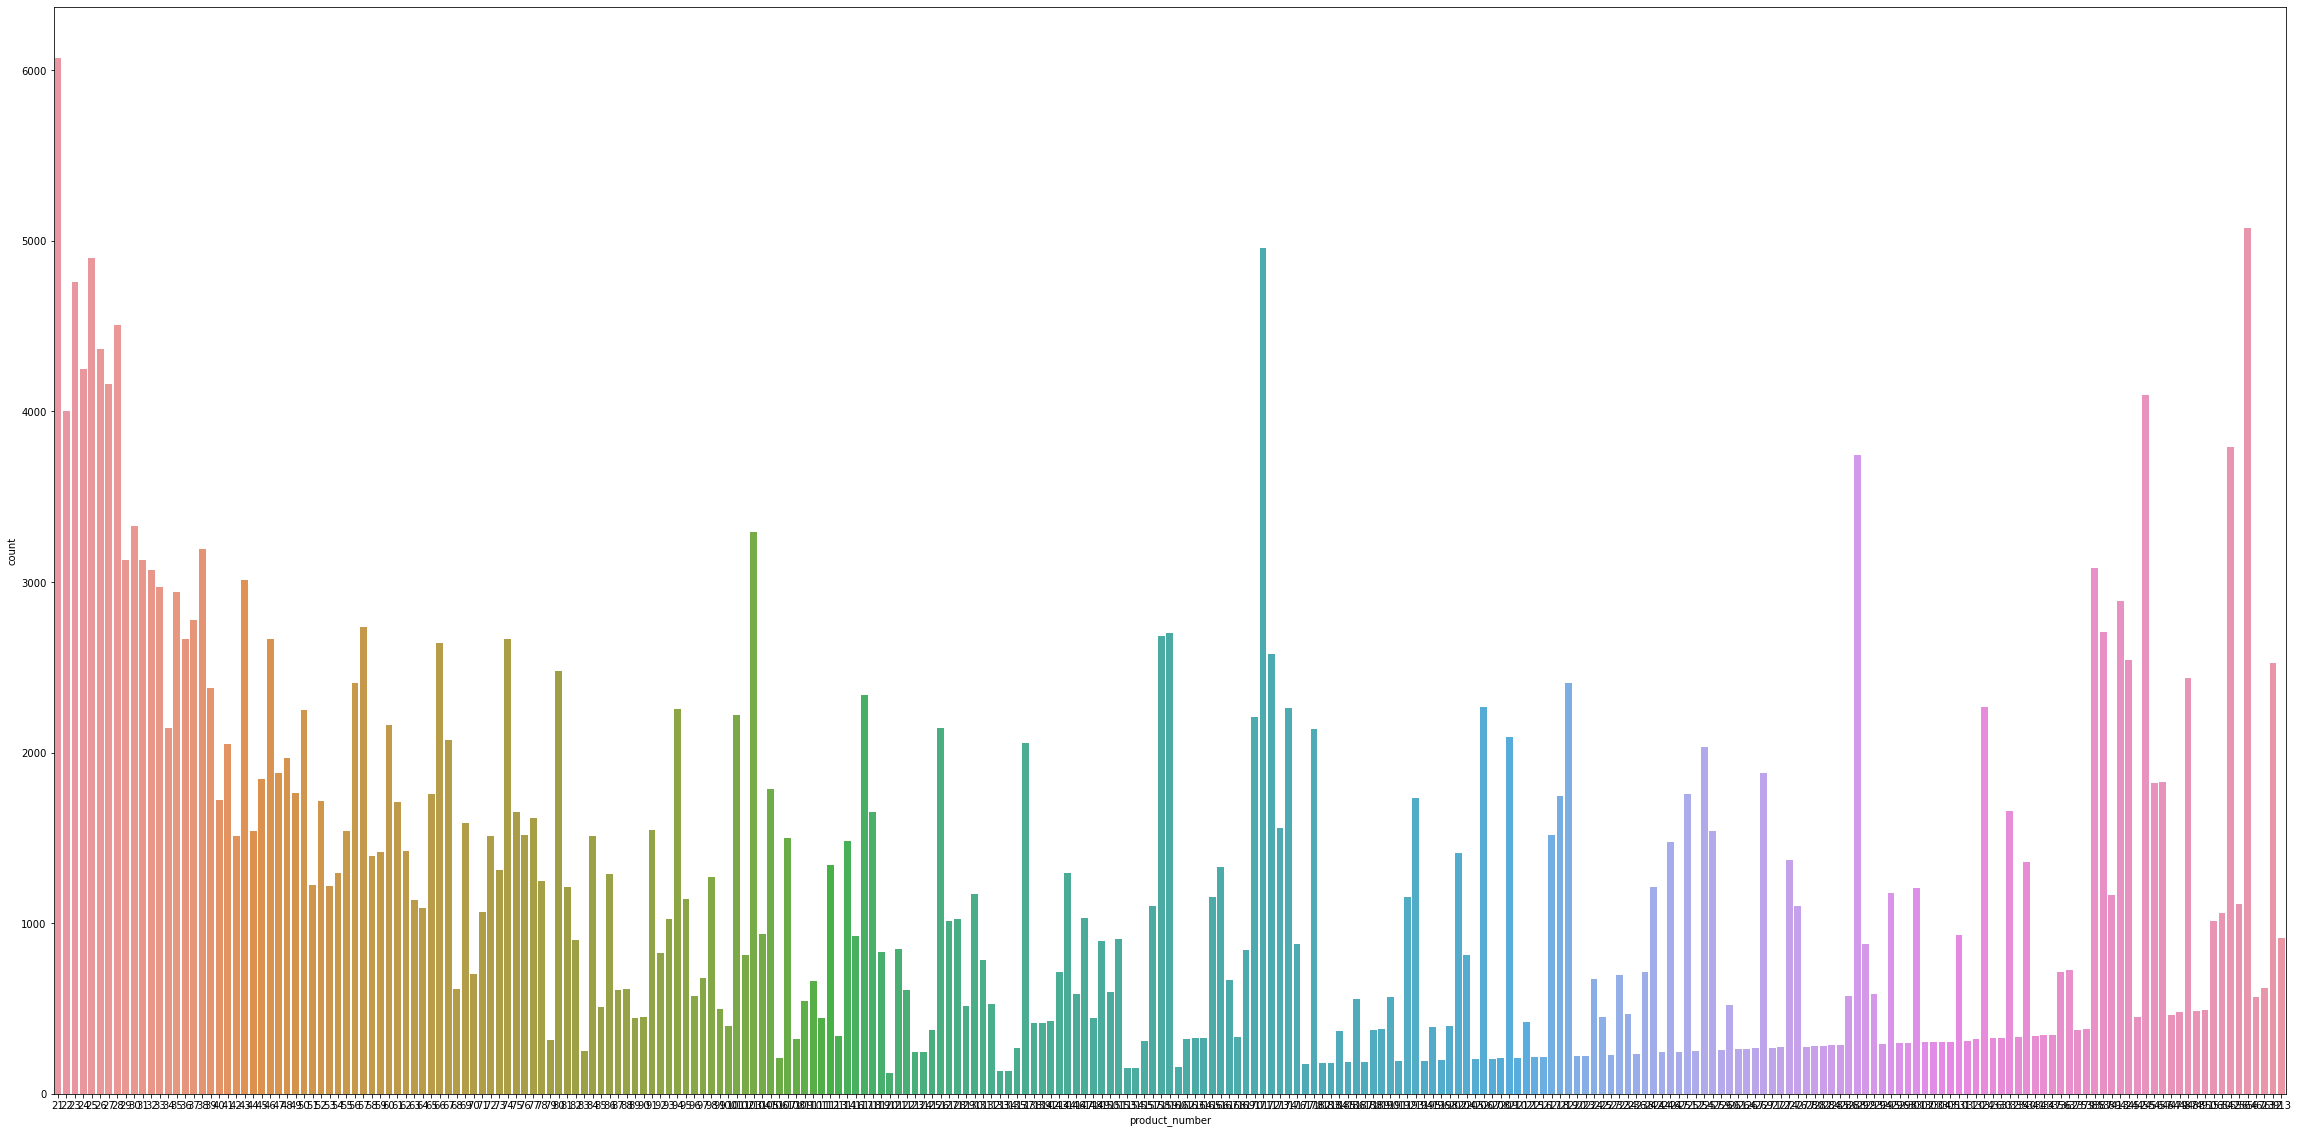

In [ ]:
plt.figure(figsize=(40,20) )
sns.countplot(x = 'product_number', data = df)

제품 갯수를 카운팅한 그래프임.

In [ ]:
df['UserId'].value_counts()

A3OXHLG6DIBRW8        236
A1TMAVN4CEM8U8        177
A3TVZM3ZIXG8YW        170
A281NPSIMI1C2R        160
A2SZLNSI5KOQJT        149
                     ... 
A2IHOUK31N323P          1
#oc-R2K1Z48V7YY9HT      1
A2JKDYLITPYHQX          1
AZT9OGZODW8VW           1
A3SOIHQ5XBSR4D          1
Name: UserId, Length: 127411, dtype: int64

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331811 entries, 0 to 331810
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ProductId       331811 non-null  object
 1   UserId          331811 non-null  object
 2   Score           331811 non-null  int64 
 3   Summary         331785 non-null  object
 4   Text            331811 non-null  object
 5   repurchase      331811 non-null  int64 
 6   product_number  331811 non-null  int64 
dtypes: int64(3), object(4)
memory usage: 30.3+ MB


In [ ]:
df = df.dropna(axis = 0)
df = df.reset_index(drop = True)
df['sat'] = df['Score']
df

,ProductId,UserId,Score,Summary,Text,repurchase,product_number,sat
0,B000CQ26E0,ABXLMWJIXXAIN,4,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ...",3,21,4
1,B000CQ26E0,A2RNYW2HIQBGSM,5,"Tastes great, easy to make",These are really good. You do need to add jus...,46,21,5
2,B000CQ26E0,AZAKCIFE27RAA,5,My Teens Favorite!,Have been buying this for 2 years. My son and ...,18,21,5
3,B000CQ26E0,A2H8OLTO0I2F6J,4,One of my travel essentials,"For constant work travel, one of my packed mea...",18,21,4
4,B000CQ26E0,A32RWGJEWFUAB,4,My 8-year-old can't live without this,Annie's Mac & Cheese is my youngest son's favo...,4,21,4
...,...,...,...,...,...,...,...,...
331780,B001OZ5FPA,A1ZDPPIKGHN6WD,5,Good choice,Was one of the less expensive bonzai trees I c...,1,22,5
331781,B001OZ5FPA,A3NE1IR0KAMB1H,1,"incomplete order, refused refund",I ordered 3 plants from this company a year ag...,1,22,1
331782,B001OZ5FPA,ADBN8RAGDGG3R,5,My First Bonsai plant...,This is my first bonsai plant. I was wondering...,1,22,5
331783,B001OZ5FPA,A3M2FA3FZ20LYG,5,Doing business with 9greenbox,I did not receive the Bonsai Juniper Tree Zen ...,1,22,5


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 331785 entries, 0 to 331784
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   ProductId       331785 non-null  object
 1   UserId          331785 non-null  object
 2   Score           331785 non-null  int64 
 3   Summary         331785 non-null  object
 4   Text            331785 non-null  object
 5   repurchase      331785 non-null  int64 
 6   product_number  331785 non-null  int64 
 7   sat             331785 non-null  int64 
dtypes: int64(4), object(4)
memory usage: 20.3+ MB


In [ ]:
for i in range(len(df)):
    if df['sat'][i] == 5 :
        df['sat'][i] = 1
    else :
        df['sat'][i] = 0
        

/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df['sat'].value_counts()[0] / len(df), df['sat'].value_counts()[1] / len(df)


(0.37421221574212216, 0.6257877842578778)

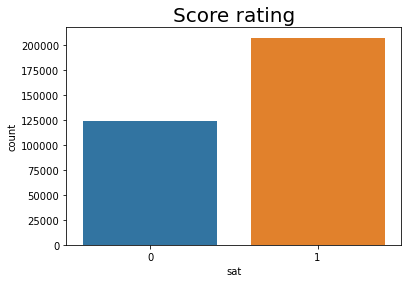

In [ ]:
plt.title('Score rating', fontsize = 20)
plt.xlabel('Score')
plt.ylabel('count')
sns.countplot(x = 'sat', data = df)

##평점이 5점인 리뷰는 62%, 평점이 4점 이하인 리뷰는 38%임.
##우리는 4점 이하인 리뷰에서 왜 리뷰가 5점이 아닌지를 파악해내는 것이 목표임.

In [ ]:
df

,ProductId,UserId,Score,Summary,Text,repurchase,product_number,sat
0,B000CQ26E0,ABXLMWJIXXAIN,4,"Fast, Easy and organic","For speed and wholesome goodness, Annie's can ...",3,21,0
1,B000CQ26E0,A2RNYW2HIQBGSM,5,"Tastes great, easy to make",These are really good. You do need to add jus...,46,21,1
2,B000CQ26E0,AZAKCIFE27RAA,5,My Teens Favorite!,Have been buying this for 2 years. My son and ...,18,21,1
3,B000CQ26E0,A2H8OLTO0I2F6J,4,One of my travel essentials,"For constant work travel, one of my packed mea...",18,21,0
4,B000CQ26E0,A32RWGJEWFUAB,4,My 8-year-old can't live without this,Annie's Mac & Cheese is my youngest son's favo...,4,21,0
...,...,...,...,...,...,...,...,...
331780,B001OZ5FPA,A1ZDPPIKGHN6WD,5,Good choice,Was one of the less expensive bonzai trees I c...,1,22,1
331781,B001OZ5FPA,A3NE1IR0KAMB1H,1,"incomplete order, refused refund",I ordered 3 plants from this company a year ag...,1,22,0
331782,B001OZ5FPA,ADBN8RAGDGG3R,5,My First Bonsai plant...,This is my first bonsai plant. I was wondering...,1,22,1
331783,B001OZ5FPA,A3M2FA3FZ20LYG,5,Doing business with 9greenbox,I did not receive the Bonsai Juniper Tree Zen ...,1,22,1


In [ ]:
len(df[df['repurchase'] > 5])/len(df)

0.4839278448392785

In [ ]:
df[df['repurchase'] > 5]

,ProductId,UserId,Score,Summary,Text,repurchase,product_number,sat
1,B000CQ26E0,A2RNYW2HIQBGSM,5,"Tastes great, easy to make",These are really good. You do need to add jus...,46,21,1
2,B000CQ26E0,AZAKCIFE27RAA,5,My Teens Favorite!,Have been buying this for 2 years. My son and ...,18,21,1
3,B000CQ26E0,A2H8OLTO0I2F6J,4,One of my travel essentials,"For constant work travel, one of my packed mea...",18,21,0
5,B000CQ26E0,A3Q8WSHXGHZIMA,5,Love it; perfect noodles take practice,"Love the flavor on this mac n cheese, but maki...",6,21,1
22,B003XDH6M6,A18ECVX2RJ7HUE,5,these are DELICIOUS!!! get some!,you know how when you bite into a nice piece o...,20,298,1
...,...,...,...,...,...,...,...,...
331351,B00315HJ8C,A195NDLY9TDPIJ,5,get one,things so yummy. tastes a little better and a...,7,35,1
331409,B005NYXE24,A26NG02R8JHR57,5,Great gift for parents and grandparents!,My boyfriend and I did combine gifts for the p...,7,29,1
331410,B005NYXE24,A2CL818RN52NWN,5,A fabulous gift for anyone who experienced the...,Remember the eighties? well anyone who does wi...,13,29,1
331439,B000OLIXO0,AZH8I0G5AJ4NJ,5,Green Tea Frappe,This is as close to Starbucks as I can get. I ...,9,35,1


In [ ]:
df = df.sort_values(['repurchase'], axis = 0, ascending = False)
df

,ProductId,UserId,Score,Summary,Text,repurchase,product_number,sat
94824,B001HX59ZU,A3OXHLG6DIBRW8,4,Good Earl Grey Tea - Recommended,"These Bigelow ""Earl Grey Tea"" K-Cups are quite...",448,28,0
103500,B000LKTW5S,A3OXHLG6DIBRW8,5,Great Tasting and Fairly Spicy - Highly Recomm...,"""Pindi Chana, Chick Pea Curry"" was one of the ...",448,48,1
95560,B001E5E2RW,A3OXHLG6DIBRW8,5,Great Diabetic Friendly Flavoring - Highly Rec...,We have tried most of the Torani Sugar-Free Sy...,448,61,1
27407,B004CYLW7A,A3OXHLG6DIBRW8,4,Good Tasting Cereal - Recommended,"This Kellogg's ""Crunchy Nut"" cereal is very go...",448,205,0
87548,B00315WGNK,A3OXHLG6DIBRW8,3,"Good Tasting and Tender, But...","While ""Wild Ride Beef Jerky Cowboy Strips"" do ...",448,172,0
...,...,...,...,...,...,...,...,...
136374,B000CSRBXY,A1LGSRHNQT27RC,5,Greatest microwave popcorn ever,This is better than most of us can do with a p...,1,25,1
136375,B000CSRBXY,ATZTE5KL3K9S7,5,This is great popcorn,This is great popcorn. I do not know why that ...,1,25,1
136376,B000CSRBXY,A1P4ADF1RCJ91U,5,Good for what it is,I appreciate short ingredient lists and this i...,1,25,1
136377,B000CSRBXY,A1Z502BOPNBJCS,4,Good shtuff,It is the 3.3oz bags just as the picture shows...,1,25,0


In [ ]:
df['Text'][331784]

'I really should have read the dimensions, it is really small and it looks like someone cut a branch off a bush. I hope it stays alive. I had one I bought from a road side vendor that was like this one and it died in a month. I had one from a florist that lived for years. I was hoping for better quality.'

# 2.Binary Classification Modeling(LSTM)

## 2-1. Train, Validation, Test 분리(0.64 / 0.16 / 0.2)

In [ ]:
from sklearn.model_selection import train_test_split

X_train1, X_test1, y_train1, y_test1= train_test_split(df['Text'], df['sat'], test_size = 0.2, random_state = 411)

In [ ]:
df.columns

Index(['ProductId', 'UserId', 'Score', 'Summary', 'Text', 'repurchase',
       'product_number', 'sat'],
      dtype='object')

In [ ]:
X_train1, X_val1, y_train1, y_val1= train_test_split(X_train1, y_train1, test_size = 0.2, random_state = 411)

In [ ]:
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((212342,), (212342,), (53086,), (53086,), (66357,), (66357,))

## 2-2. 토큰화 진행

In [ ]:
from keras.preprocessing.text import Tokenizer

max_features = 15000 #최대 토큰 수
maxlen = 100 #100개로 균일하게 맞춤
batch_size = 128


tok = Tokenizer(num_words = max_features)
tok.fit_on_texts(X_train1)

In [ ]:
pip install keras

Note: you may need to restart the kernel to use updated packages.


In [ ]:
print(len(tok.word_index))

71382


In [ ]:
tok.word_index

{'the': 1,
 'i': 2,
 'and': 3,
 'a': 4,
 'to': 5,
 'it': 6,
 'of': 7,
 'is': 8,
 'br': 9,
 'this': 10,
 'for': 11,
 'in': 12,
 'my': 13,
 'that': 14,
 'but': 15,
 'have': 16,
 'with': 17,
 'not': 18,
 'you': 19,
 'are': 20,
 'was': 21,
 'they': 22,
 'as': 23,
 'like': 24,
 'on': 25,
 'so': 26,
 'these': 27,
 'them': 28,
 'coffee': 29,
 'good': 30,
 'be': 31,
 'or': 32,
 'taste': 33,
 'one': 34,
 'at': 35,
 'just': 36,
 'if': 37,
 'great': 38,
 'very': 39,
 'all': 40,
 'product': 41,
 'flavor': 42,
 "it's": 43,
 'more': 44,
 'me': 45,
 'food': 46,
 'from': 47,
 'when': 48,
 'has': 49,
 'we': 50,
 'can': 51,
 'tea': 52,
 'love': 53,
 'would': 54,
 'will': 55,
 'had': 56,
 'out': 57,
 'than': 58,
 'no': 59,
 'get': 60,
 'other': 61,
 'about': 62,
 'up': 63,
 'really': 64,
 'some': 65,
 'only': 66,
 'too': 67,
 'amazon': 68,
 'much': 69,
 "don't": 70,
 'an': 71,
 'your': 72,
 'also': 73,
 'because': 74,
 'little': 75,
 'do': 76,
 'time': 77,
 'she': 78,
 'there': 79,
 'tried': 80,
 'use': 

## 2-3. Train, Validation, Test 벡터화 진행

In [ ]:
sequences = tok.texts_to_sequences(X_train1)
print(len(sequences[0]))
print(sequences[0])

73
[99, 84, 283, 5, 2657, 116, 2, 80, 162, 41, 57, 79, 1935, 8, 1, 66, 116, 892, 14, 64, 134, 24, 116, 2, 143, 61, 320, 104, 10, 1806, 15, 10, 41, 64, 146, 43, 159, 67, 129, 47, 9898, 18, 404, 19, 2407, 6, 36, 24, 116, 43, 14, 875, 9, 2, 436, 6, 21, 760, 5, 108, 12, 358, 87, 249, 712, 226, 35, 4, 77, 5, 390, 25, 336]


In [ ]:
X_train1

146268    I've been trying to quit sugar.  I tried every...
86663     This syrup is great.  It is pure maple.  It is...
146515    this is a wonderful product. it is sweet and n...
230637    This product is fantastic.  I am a weight watc...
100847    Yum!  All the convenience you expect with a K-...
                                ...                        
2293      The flavor of the No Fear, Super Energy drink ...
40516     Upon receiving these, I was very surprised reg...
234514    Great price compared to the supermarkets.  My ...
202129    I have tried just about every brand and this i...
240612    I eat Genova Tonno tuna every week. It is pack...
Name: Text, Length: 212342, dtype: object

In [ ]:
sequences_matrix = sequence.pad_sequences(sequences, maxlen = maxlen)
print(len(sequences_matrix))
print(sequences_matrix[0])

212342
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0   99
   84  283    5 2657  116    2   80  162   41   57   79 1935    8    1
   66  116  892   14   64  134   24  116    2  143   61  320  104   10
 1806   15   10   41   64  146   43  159   67  129   47 9898   18  404
   19 2407    6   36   24  116   43   14  875    9    2  436    6   21
  760    5  108   12  358   87  249  712  226   35    4   77    5  390
   25  336]


In [ ]:
sequences_val = tok.texts_to_sequences(X_val1)
sequences_val_matrix = sequence.pad_sequences(sequences_val, maxlen = maxlen)

sequences_test = tok.texts_to_sequences(X_test1)
sequences_test_matrix = sequence.pad_sequences(sequences_test, maxlen = maxlen)

In [ ]:
sequences_matrix.shape, sequences_val_matrix.shape, sequences_test_matrix.shape

((212342, 100), (53086, 100), (66357, 100))

In [ ]:
y_train1

146268    1
86663     1
146515    1
230637    1
100847    1
         ..
2293      0
40516     1
234514    1
202129    1
240612    1
Name: sat, Length: 212342, dtype: int64

## 2-4. LSTM 이진분류 모델링

In [ ]:
import tensorflow as tf

model_sat = tf.keras.models.Sequential([ 
    tf.keras.layers.Embedding(max_features, 128),
    tf.keras.layers.LSTM(256, dropout = 0.3, recurrent_dropout = 0.3),
    tf.keras.layers.Dense(1, activation = 'sigmoid')
])

model_sat.compile(loss = 'binary_crossentropy',
             optimizer = 'adam',
             metrics = ['accuracy'])

model_sat.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 128)         1920000   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dense (Dense)                (None, 1)                 257       
Total params: 2,314,497
Trainable params: 2,314,497
Non-trainable params: 0
_________________________________________________________________


In [ ]:
unicorns = model_sat.fit(sequences_matrix, y_train1,
          batch_size=batch_size, 
          epochs=5,
          validation_data=(sequences_val_matrix, y_val1))

Epoch 1/5
1659/1659 [==============================] - 1099s 662ms/step - loss: 0.4124 - accuracy: 0.8211 - val_loss: 0.3745 - val_accuracy: 0.8448
Epoch 2/5
1659/1659 [==============================] - 1113s 671ms/step - loss: 0.3288 - accuracy: 0.8663 - val_loss: 0.3352 - val_accuracy: 0.8645
Epoch 3/5
1659/1659 [==============================] - 1121s 676ms/step - loss: 0.2816 - accuracy: 0.8899 - val_loss: 0.3277 - val_accuracy: 0.8704
Epoch 4/5
1659/1659 [==============================] - 1122s 677ms/step - loss: 0.2432 - accuracy: 0.9060 - val_loss: 0.3252 - val_accuracy: 0.8773
Epoch 5/5
1659/1659 [==============================] - 1112s 670ms/step - loss: 0.2104 - accuracy: 0.9201 - val_loss: 0.3271 - val_accuracy: 0.8847


In [ ]:
model_sat.save('binary_class')

INFO:tensorflow:Assets written to: binary_class/assets


## 2-5. 모델링 평가 시각화

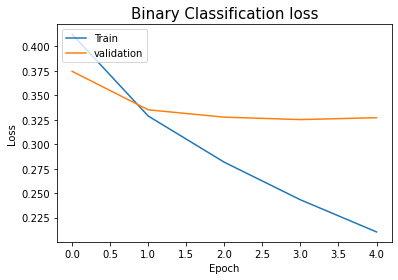

In [ ]:
# Plot training & validation loss values
plt.plot(unicorns.history['loss'])
plt.plot(unicorns.history['val_loss'])
plt.title('Binary Classification loss', fontsize = 15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show();

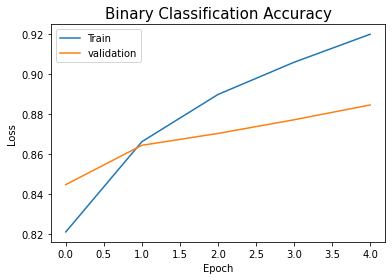

In [ ]:
# Plot training & validation loss values
plt.plot(unicorns.history['accuracy'])
plt.plot(unicorns.history['val_accuracy'])
plt.title('Binary Classification Accuracy', fontsize = 15)
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'validation'], loc='upper left')
plt.show();

## 2-6. 테스트셋 평가

In [ ]:
lstm_score = model_sat.evaluate(sequences_matrix, y_train1)

6636/6636 [==============================] - 451s 68ms/step - loss: 0.1547 - accuracy: 0.9443


In [ ]:
lstm_score_val = model_sat.evaluate(sequences_val_matrix, y_val1)

1659/1659 [==============================] - 123s 74ms/step - loss: 0.3271 - accuracy: 0.8847


In [ ]:
lstm_score_test = model_sat.evaluate(sequences_val_matrix, y_val1)

1659/1659 [==============================] - 115s 69ms/step - loss: 0.3271 - accuracy: 0.8847


In [ ]:

LSTM_score = pd.DataFrame({'DATA' : ['Binary_Train', 'Binary_Validation', 'Binary_Test'], 'LOSS' : [lstm_score[0], lstm_score_val[0], lstm_score_test[0]], 'ACCURACY' : [lstm_score[1], lstm_score_val[1], lstm_score_test[1]]})
LSTM_score

,DATA,LOSS,ACCURACY
0,Binary_Train,0.154724,0.944288
1,Binary_Validation,0.327115,0.884678
2,Binary_Test,0.327115,0.884678


## 우선적으로, 이진 분류를 진행해보았음.
### 이진 분류는 5점과 4점 이하로 나누어서 진행했으며, 4점 이하는 어느 정도 불만족하는 점들이 있다고 판단되었기 때문에 진행했음.
### LSTM을 모델링한 결과, 정확도는 0.88로 꽤나 높은 성능이 나오는 것을 확인할 수 있음


## 2-7. CV 진행

In [ ]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

# model = KerasClassifier(build_fn=create_model, epochs=150, batch_size=10, verbose=2)   
kfold = KFold(n_splits=5, shuffle=True, random_state=411)

results = cross_val_score(model_sat, sequences_matrix, y_train1, scoring = 'accuracy', cv=kfold)

results


TypeError: Cannot clone object '<tensorflow.python.keras.engine.sequential.Sequential object at 0x7facf48c7090>' (type <class 'tensorflow.python.keras.engine.sequential.Sequential'>): it does not seem to be a scikit-learn estimator as it does not implement a 'get_params' method.

In [ ]:
y_train1

146268    1
86663     1
146515    1
230637    1
100847    1
         ..
2293      0
40516     1
234514    1
202129    1
240612    1
Name: sat, Length: 212342, dtype: int64

In [ ]:
y_train1.shape, y_val1.shape, y_test1.shape

((212342,), (53086,), (66357,))

## epoch이 올라갈수록 훈련 정확도는 올라가지만, 반대로 검증 정확도는 낮아지는 것을 볼 때, 과적합이 되는 것으로 파악됨. 그렇다면 하이퍼 파라미터 튜닝을 다시 진행하여야 할 듯.

In [ ]:
np.random.seed(411)
tf.random.set_seed(411)

import keras
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras import regularizers

In [ ]:
checkpoint_filepath = "FMbest.hdf5"

# overfitting을 방지하기 위해서 학습 중 early stop을 수행하기 위한 코드입니다.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1)

# Validation Set을 기준으로 가장 최적의 모델을 찾기 위한 코드입니다.
save_best = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath, monitor='val_loss', verbose=1, save_best_only=True,
    save_weights_only=True, mode='auto', save_freq='epoch', options=None)

In [ ]:
pip install sentencepiece

Note: you may need to restart the kernel to use updated packages.


## LSTM으로 모델링을 한 결과, epochs가 늘어날수록 train loss는 줄어드는 반면에, validation loss는 늘어나는 것을 볼 수 있음. 

## 반면에, test data를 evaluate한 결과, 정확도가 약 81%로 괜찮은 성능이 나오는 것을 볼 수 있음.
## 이를 통해서, 데이터를 랜덤으로 분할했지만 train data와 test data가 어느 정도 유사한 데이터로 유추할 수 있고, validation은 유사하지 않은 리뷰가 많았던 것으로 추론할 수 있음.

## 그렇다면, 일반 머신 러닝 모델과 bert를 활용하여 모델링을 진행하여 성능일 비교해보겠음.
## 내가 의도한 것은 결국, 고객님들 중 재구매량이 낮은 고객님일수록 불만족적인 특정 단어를 자주 사용하지 않을까라는 생각을 했고, tf-idf를 통해서 머신러닝 모델링을 우선적으로 진행해보겠음.



### 원하는 결과 : LSTM보다 높은 예측도가 나오는 것. 아무래도, 문맥의 의미만큼이나 부정적인 단어가 나올 때 얼마나 재구매에 영향에 미치는지를 파악해야 하는데, 부정적인 단어의 빈도수를 통해 예측하는 것임.
### 부정적인 단어 중에서 특정 단어가 많이 나오는 경우, 재구매에 크게 영향을 미친다고 판단할 수 있기 때문에, 해당 단어를 비즈니스 운영에 있어서 개선이 필요하다고 판단
### 예를 들자면, 가격에 대한 불만, 배송에 대한 불만, 상품에 대한 불만, 고객 서비스에 대한 불만 등을 통해서 어떠한 점이 자사가 운영하는 서비스에서 고객님들이 불편함을 느끼는지를 파악하고, 이를 개선하는 활동을 통해 재구매율을 증대시키는 효과를 기대함.

### 목표는 0으로 분류된 고객님을 1로 올라올 수 있도록 하는 것이 목표임.
### 그렇게 하기 위해서 0으로 분류된 고객님들의 리뷰 텍스트들을 텍스트 요약 모델링을 돌린 후, 인사이트 도출해야 함.

In [ ]:
nlp = spacy.load("en_core_web_sm")

def tokenize(document):
    
    doc = nlp(document)
    # punctuations: !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    return [token.lemma_.strip() for token in doc if (token.is_stop != True) and (token.is_punct != True) and (token.is_alpha == True)]

In [ ]:
vect = TfidfVectorizer(stop_words='english',
                       tokenizer = tokenize
                       ,ngram_range=(1,2)
                        ,max_df=.7
                        ,min_df=3,
                       max_features = 10000)
dtm = vect.fit_transform(df['Text'])
dtm = pd.DataFrame(dtm.todense(), columns = vect.get_feature_names())

dtm

,0,0br,1,1 12,1 2,1 bag,1 cup,1 gram,1 lb,1 oz,...,zing,zip,zip lock,ziploc,ziplock,ziplock bag,ziwipeak,zoe,zukes,zukes mini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331780,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331781,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
331783,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
dtm.shape, df['sat'].shape

((331785, 10000), (331785,))

In [ ]:
rfc = RandomForestClassifier(n_estimators = 10, n_jobs = -1, random_state = 411)


X_train_tf, X_test_tf, y_train_tf, y_test_tf = train_test_split(dtm, df['sat'], test_size=0.2, random_state=411)
X_train_tf, X_val_tf, y_train_tf, y_val_tf = train_test_split(X_train_tf, y_train_tf, test_size=0.2, random_state=411)

rfc.fit(X_train_tf, y_train_tf)

rfc.score(X_val_tf, y_val_tf)

In [ ]:
print('랜덤포레스트 검증 정확도', rfc.score(X_val_tf, y_val_tf))
print('랜덤포레스트 테스트 정확도', rfc.score(X_test_tf, y_test_tf))

### 랜덤포레스트 돌리니까, 서버가 터저버렸다....

In [ ]:
pip install beautifulsoup4

Note: you may need to restart the kernel to use updated packages.


## 1. 고객 리뷰를 통해서 만족, 불만족으로 이진 분류 진행(만족은 5점, 불만족은 4점 이하)
## 2. 불만족으로 예측한 고객의 리뷰를 다시 요약문 모델링으로 투입
## 3. 요약문 모델링을 통해서 텍스트 요약문 추출 - 여기까지가 이번 프로젝트 완료 단계
## 4. 추출된 요약문으로 다중 분류 진행(만족, 상품에 대한 이슈, 고객 서비스에 대한 이슈, 배송에 대한 이슈 등)
## 5. 다중 분류를 통해서 모든 고객님들의 피드백을 읽어볼 필요 없이, 자사의 제품이나 서비스에서 고객님들이 어떠한 불만족이 있는지를 자동화 과정을 통해서 파악하는 것이 목표임
## 6. 제품 및 서비스 개선 작업을 통해서 재구매 고객을 늘리는 것이 최종 목표.

## 추상적 요약 방식으로 진행이 되기 때문에 summary의 레이블이 있어야 함. 그렇기 때문에, 데이터를 자체적으로 재구성할 수 있는 시스템이 필요한데, 이 또한 어떻게 보면 어느 정도 어려움이 있을 수 있을 것이라 판단함. 

# 3.Text Summarization Modeling(Attention & LSTM)

In [ ]:
import re
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
from nltk.corpus import stopwords 

np.random.seed(seed=411)

In [ ]:
df

,ProductId,UserId,Score,Summary,Text,repurchase,product_number,sat
94824,B001HX59ZU,A3OXHLG6DIBRW8,4,Good Earl Grey Tea - Recommended,"These Bigelow ""Earl Grey Tea"" K-Cups are quite...",448,28,0
103500,B000LKTW5S,A3OXHLG6DIBRW8,5,Great Tasting and Fairly Spicy - Highly Recomm...,"""Pindi Chana, Chick Pea Curry"" was one of the ...",448,48,1
95560,B001E5E2RW,A3OXHLG6DIBRW8,5,Great Diabetic Friendly Flavoring - Highly Rec...,We have tried most of the Torani Sugar-Free Sy...,448,61,1
27407,B004CYLW7A,A3OXHLG6DIBRW8,4,Good Tasting Cereal - Recommended,"This Kellogg's ""Crunchy Nut"" cereal is very go...",448,205,0
87548,B00315WGNK,A3OXHLG6DIBRW8,3,"Good Tasting and Tender, But...","While ""Wild Ride Beef Jerky Cowboy Strips"" do ...",448,172,0
...,...,...,...,...,...,...,...,...
136374,B000CSRBXY,A1LGSRHNQT27RC,5,Greatest microwave popcorn ever,This is better than most of us can do with a p...,1,25,1
136375,B000CSRBXY,ATZTE5KL3K9S7,5,This is great popcorn,This is great popcorn. I do not know why that ...,1,25,1
136376,B000CSRBXY,A1P4ADF1RCJ91U,5,Good for what it is,I appreciate short ingredient lists and this i...,1,25,1
136377,B000CSRBXY,A1Z502BOPNBJCS,4,Good shtuff,It is the 3.3oz bags just as the picture shows...,1,25,0


## 3-1. 데이터 전처리

In [ ]:
df_sum = df[['Text', 'Summary','repurchase', 'sat']]
df_sum

,Text,Summary,repurchase,sat
94824,"These Bigelow ""Earl Grey Tea"" K-Cups are quite...",Good Earl Grey Tea - Recommended,448,0
103500,"""Pindi Chana, Chick Pea Curry"" was one of the ...",Great Tasting and Fairly Spicy - Highly Recomm...,448,1
95560,We have tried most of the Torani Sugar-Free Sy...,Great Diabetic Friendly Flavoring - Highly Rec...,448,1
27407,"This Kellogg's ""Crunchy Nut"" cereal is very go...",Good Tasting Cereal - Recommended,448,0
87548,"While ""Wild Ride Beef Jerky Cowboy Strips"" do ...","Good Tasting and Tender, But...",448,0
...,...,...,...,...
136374,This is better than most of us can do with a p...,Greatest microwave popcorn ever,1,1
136375,This is great popcorn. I do not know why that ...,This is great popcorn,1,1
136376,I appreciate short ingredient lists and this i...,Good for what it is,1,1
136377,It is the 3.3oz bags just as the picture shows...,Good shtuff,1,0


In [ ]:
df_sum['Text'].nunique(), df_sum['Summary'].nunique()

(180982, 142353)

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jaehyeonglee/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
stop_words = set(stopwords.words('english'))
print('불용어 개수 :', len(stop_words))
print(stop_words)

불용어 개수 : 179
{'our', 'its', 'shan', 'him', 'against', "should've", 'they', 'as', 'when', "wouldn't", 'ours', 'not', 'she', 'do', 't', "it's", 'having', 'than', 'were', 'why', 'my', 'being', 'because', "needn't", 'by', 'of', 'both', 'that', "wasn't", 'himself', 'about', 'was', 'any', 'itself', 'herself', "don't", 'these', 'there', 'all', 'from', 'shouldn', 'her', "mustn't", 'haven', 'have', 'this', 'does', 'doing', 'again', 'had', 'be', 'what', 'just', 'their', 'now', 've', 'don', 'other', 'below', 'once', 'me', "aren't", 'or', 's', 'here', 'you', 'can', 'between', "shan't", 'if', 'theirs', 'at', 'hers', 'it', 'm', "that'll", "didn't", 'own', 'needn', 'how', 'which', 'where', 'won', 'no', 'too', 'ma', 'isn', 'until', "shouldn't", 'out', 'doesn', 'those', "doesn't", 'them', 'before', 'will', 'your', 'such', 'didn', 'are', "weren't", 'o', 'the', 'couldn', 'weren', 'his', 'under', 're', "you've", 'yourselves', "couldn't", 'a', 'mustn', 'over', 'who', 'we', "you're", 'myself', 'each', "you'

In [ ]:
def preprocess_sentence(sentence, remove_stopwords = True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열  제거 Ex) my husband (and myself) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
#     sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","",sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah

    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stop_words if len(word) > 1)
    # 불용어 미제거 (Summary)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [ ]:
clean_text = []
for s in df_sum['Text']:
    clean_text.append(preprocess_sentence(s))
clean_text[:5]

['bigelow earl grey tea cups quite good made keurig elite gourmet single cup home brewing system small large cup settings better earl grey tea speed convenience compensates recommended cfh',
 'pindi chana chick pea curry one meals included kitchens india ready eat dinner variety pack ounce boxes much enjoyed dish found authentic tasting fairly spicy packet makes servings family makes excellent main course side dish indian themed dinner makes enjoyable snack well stirred well serving since oils tenancy separate recommended cfh',
 'tried torani sugar free syrup flavors enjoyed caramel syrup also good goes well regular coffee frappes diabetic fantastic great tasting sugar free syrups available fake aftertaste highly recommended cfh',
 'kellogg crunchy nut cereal good tasting fairly filling honey nut cereal flavors well balanced work well together reminding honey nut cheerios kids really liked high sugar makes treat us rather breakfast staple recommended based flavor health aspects cfh',
 

In [ ]:
clean_summary = []
for s in df_sum['Summary']:
    clean_summary.append(preprocess_sentence(s, 0))
clean_summary[:5]

/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/bs4/__init__.py:219: UserWarning: "b'.'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/bs4/__init__.py:282: UserWarning: "http://www.amazon.com/gp/product/b007i7yygy/ref=cm_cr_rev_prod_title" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup


['good earl grey tea recommended',
 'great tasting and fairly spicy highly recommended',
 'great diabetic friendly flavoring highly recommended',
 'good tasting cereal recommended',
 'good tasting and tender but']

In [ ]:
df_sum['Text1'] = clean_text
df_sum['Summary1'] = clean_summary

df_sum.replace('', np.nan, inplace=True)
print(df_sum.isnull().sum())

/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/pandas/core/frame.py:4172: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

Text            0
Summary         0
repurchase      0
sat             0
Text1           1
Summary1      227
dtype: int64


In [ ]:
df_sum.dropna(axis = 0, inplace = True)
print('전체 샘플수 :',(len(df_sum)))

전체 샘플수 : 331558


/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_sum.shape

(331558, 6)

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 1918
텍스트의 평균 길이 : 39.76701512254266
요약의 최소 길이 : 1
요약의 최대 길이 : 27
요약의 평균 길이 : 4.032452843846325


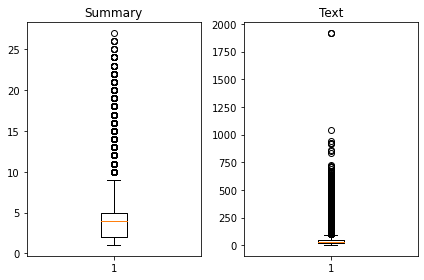

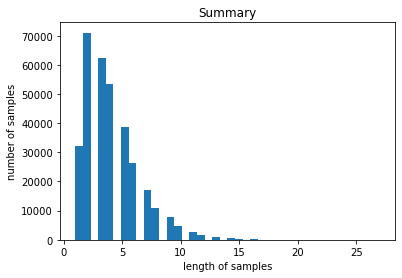

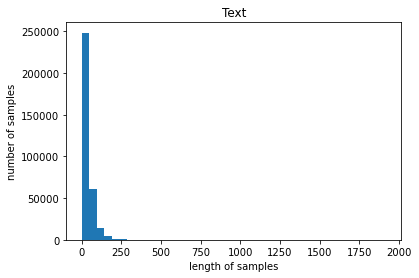

In [ ]:
text_len = [len(s.split()) for s in df_sum['Text1']]
summary_len = [len(s.split()) for s in df_sum['Summary1']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(summary_len)))
print('요약의 최대 길이 : {}'.format(np.max(summary_len)))
print('요약의 평균 길이 : {}'.format(np.mean(summary_len)))

plt.subplot(1,2,1)
plt.boxplot(summary_len)
plt.title('Summary')
plt.subplot(1,2,2)
plt.boxplot(text_len)
plt.title('Text')
plt.tight_layout()
plt.show()

plt.title('Summary')
plt.hist(summary_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('Text')
plt.hist(text_len, bins=40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [ ]:
text_max_len = 70
summary_max_len = 8

In [ ]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [ ]:
below_threshold_len(text_max_len, df_sum['Text1'])

전체 샘플 중 길이가 70 이하인 샘플의 비율: 0.8705837289403362


In [ ]:
below_threshold_len(summary_max_len, df_sum['Summary1'])

전체 샘플 중 길이가 8 이하인 샘플의 비율: 0.942290639948365


In [ ]:
df_sum = df_sum[df_sum['Text1'].apply(lambda x: len(x.split()) <= text_max_len)]
df_sum = df_sum[df_sum['Summary1'].apply(lambda x: len(x.split()) <= summary_max_len)]
print('전체 샘플수 :',(len(df_sum)))

전체 샘플수 : 275999


In [ ]:
df_sum

,Text,Summary,repurchase,sat,Text1,Summary1
94824,"These Bigelow ""Earl Grey Tea"" K-Cups are quite...",Good Earl Grey Tea - Recommended,448,0,bigelow earl grey tea cups quite good made keu...,good earl grey tea recommended
103500,"""Pindi Chana, Chick Pea Curry"" was one of the ...",Great Tasting and Fairly Spicy - Highly Recomm...,448,1,pindi chana chick pea curry one meals included...,great tasting and fairly spicy highly recommended
95560,We have tried most of the Torani Sugar-Free Sy...,Great Diabetic Friendly Flavoring - Highly Rec...,448,1,tried torani sugar free syrup flavors enjoyed ...,great diabetic friendly flavoring highly recom...
27407,"This Kellogg's ""Crunchy Nut"" cereal is very go...",Good Tasting Cereal - Recommended,448,0,kellogg crunchy nut cereal good tasting fairly...,good tasting cereal recommended
87548,"While ""Wild Ride Beef Jerky Cowboy Strips"" do ...","Good Tasting and Tender, But...",448,0,wild ride beef jerky cowboy strips good hickor...,good tasting and tender but
...,...,...,...,...,...,...
136374,This is better than most of us can do with a p...,Greatest microwave popcorn ever,1,1,better us pot oil way healthier though salty t...,greatest microwave popcorn ever
136375,This is great popcorn. I do not know why that ...,This is great popcorn,1,1,great popcorn know day age stores stopped carr...,this is great popcorn
136376,I appreciate short ingredient lists and this i...,Good for what it is,1,1,appreciate short ingredient lists great tastin...,good for what it is
136377,It is the 3.3oz bags just as the picture shows...,Good shtuff,1,0,oz bags picture shows several dairy intolerant...,good shtuff


In [ ]:
df_sum['decoder_input'] = df_sum['Summary1'].apply(lambda x : 'sostoken '+ x)
df_sum['decoder_target'] = df_sum['Summary1'].apply(lambda x : x + ' eostoken')
df_sum.head()

,Text,Summary,repurchase,sat,Text1,Summary1,decoder_input,decoder_target
94824,"These Bigelow ""Earl Grey Tea"" K-Cups are quite...",Good Earl Grey Tea - Recommended,448,0,bigelow earl grey tea cups quite good made keu...,good earl grey tea recommended,sostoken good earl grey tea recommended,good earl grey tea recommended eostoken
103500,"""Pindi Chana, Chick Pea Curry"" was one of the ...",Great Tasting and Fairly Spicy - Highly Recomm...,448,1,pindi chana chick pea curry one meals included...,great tasting and fairly spicy highly recommended,sostoken great tasting and fairly spicy highly...,great tasting and fairly spicy highly recommen...
95560,We have tried most of the Torani Sugar-Free Sy...,Great Diabetic Friendly Flavoring - Highly Rec...,448,1,tried torani sugar free syrup flavors enjoyed ...,great diabetic friendly flavoring highly recom...,sostoken great diabetic friendly flavoring hig...,great diabetic friendly flavoring highly recom...
27407,"This Kellogg's ""Crunchy Nut"" cereal is very go...",Good Tasting Cereal - Recommended,448,0,kellogg crunchy nut cereal good tasting fairly...,good tasting cereal recommended,sostoken good tasting cereal recommended,good tasting cereal recommended eostoken
87548,"While ""Wild Ride Beef Jerky Cowboy Strips"" do ...","Good Tasting and Tender, But...",448,0,wild ride beef jerky cowboy strips good hickor...,good tasting and tender but,sostoken good tasting and tender but,good tasting and tender but eostoken


In [ ]:
df_sum.shape

(275999, 8)

## 3-2. 벡터화 진행

In [ ]:
encoder_input = np.array(df_sum['Text1'])
decoder_input = np.array(df_sum['decoder_input'])
decoder_target = np.array(df_sum['decoder_target'])

In [ ]:
indices = np.arange(encoder_input.shape[0]) ## 랜덤으로 섞기.
np.random.shuffle(indices)
print(indices)

[  7406 160345  33517 ... 131340  57796 105436]


In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

In [ ]:
indices

array([  7406, 160345,  33517, ..., 131340,  57796, 105436])

In [ ]:
len(indices)

275999

## 3-3. Train, Test 분할(8:2)

In [ ]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :',n_of_val)

테스트 데이터의 수 : 55199


In [ ]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

In [ ]:
print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 220800
훈련 레이블의 개수 : 220800
테스트 데이터의 개수 : 55199
테스트 레이블의 개수 : 55199


## 3-4. 추가적인 전처리(빈도가 적은 단어 제외)

In [ ]:
src_tokenizer = Tokenizer()
src_tokenizer.fit_on_texts(encoder_input_train)

In [ ]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 50948
등장 빈도가 6번 이하인 희귀 단어의 수: 33564
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 17384
단어 집합에서 희귀 단어의 비율: 65.87893538509853
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.0996675255389134


In [ ]:
src_vocab = 10000
src_tokenizer = Tokenizer(num_words = src_vocab) 
src_tokenizer.fit_on_texts(encoder_input_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

In [ ]:
print(encoder_input_train[:3])

[[149, 199, 638, 939, 216, 522, 111, 40, 37, 80, 4, 58, 32, 1022], [433, 13, 9192, 1629, 487, 14, 680, 1001, 2, 78, 31, 87, 3909, 1119, 76, 4548, 10, 1119, 5, 37, 6321, 5650, 69, 1654, 50, 29, 895, 166, 314, 572, 86, 853, 22, 58, 100], [249, 43, 817, 728, 68, 663, 116, 176, 68, 3082, 7, 281, 111]]


In [ ]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

In [ ]:
threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 15000
등장 빈도가 5번 이하인 희귀 단어의 수: 9600
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 5400
단어 집합에서 희귀 단어의 비율: 64.0
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.861616993777551


In [ ]:
tar_vocab = 4000
tar_tokenizer = Tokenizer(num_words = tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

In [ ]:
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

In [ ]:
print(decoder_input_train[:5])

[[1, 1899], [1, 2095, 856, 377, 42, 14], [1, 28, 90], [1, 9, 25], [1, 1445, 221, 135]]


In [ ]:
print(decoder_target_train[:5])

[[1899, 2], [2095, 856, 377, 42, 14, 2], [28, 90, 2], [9, 25, 2], [1445, 221, 135, 2]]


In [ ]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

In [ ]:
print('삭제할 훈련 데이터의 개수 :',len(drop_train))
print('삭제할 테스트 데이터의 개수 :',len(drop_test))

삭제할 훈련 데이터의 개수 : 2518
삭제할 테스트 데이터의 개수 : 660


In [ ]:
encoder_input_train = np.delete(encoder_input_train, drop_train, axis=0)
decoder_input_train = np.delete(decoder_input_train, drop_train, axis=0)
decoder_target_train = np.delete(decoder_target_train, drop_train, axis=0)

encoder_input_test = np.delete(encoder_input_test, drop_test, axis=0)
decoder_input_test = np.delete(decoder_input_test, drop_test, axis=0)
decoder_target_test = np.delete(decoder_target_test, drop_test, axis=0)

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :',len(decoder_input_train))
print('테스트 데이터의 개수 :',len(encoder_input_test))
print('테스트 레이블의 개수 :',len(decoder_input_test))

훈련 데이터의 개수 : 218282
훈련 레이블의 개수 : 218282
테스트 데이터의 개수 : 54539
테스트 레이블의 개수 : 54539


In [ ]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen = text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen = text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen = summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen = summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen = summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen = summary_max_len, padding='post')

## 3-5. Text Summarization Modeling 진행

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [ ]:
# 디코더
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences = True, return_state = True, dropout = 0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state = [state_h, state_c])

In [ ]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation = 'softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 70, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [ ]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/thushv89/attention_keras/master/src/layers/attention.py", filename="attention.py")
from attention import AttentionLayer

In [ ]:
attn_layer = AttentionLayer(name='attention_layer')
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs])

# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis = -1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 70, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience = 2)
history = model.fit(x = [encoder_input_train, decoder_input_train], y = decoder_target_train, \
          validation_data = ([encoder_input_test, decoder_input_test], decoder_target_test),
          batch_size = 256, callbacks=[es], epochs = 10)

Epoch 1/10
853/853 [==============================] - 2820s 3s/step - loss: 2.5450 - accuracy: 0.6042 - val_loss: 2.2530 - val_accuracy: 0.6258
Epoch 2/10
853/853 [==============================] - 2774s 3s/step - loss: 2.1406 - accuracy: 0.6357 - val_loss: 2.0341 - val_accuracy: 0.6454
Epoch 3/10
853/853 [==============================] - 2677s 3s/step - loss: 1.9767 - accuracy: 0.6505 - val_loss: 1.9135 - val_accuracy: 0.6581
Epoch 4/10
853/853 [==============================] - 2819s 3s/step - loss: 1.8676 - accuracy: 0.6616 - val_loss: 1.8274 - val_accuracy: 0.6682
Epoch 5/10
853/853 [==============================] - 2796s 3s/step - loss: 1.7852 - accuracy: 0.6715 - val_loss: 1.7673 - val_accuracy: 0.6756
Epoch 6/10
853/853 [==============================] - 2740s 3s/step - loss: 1.7222 - accuracy: 0.6796 - val_loss: 1.7161 - val_accuracy: 0.6837
Epoch 7/10
853/853 [==============================] - 2548s 3s/step - loss: 1.6683 - accuracy: 0.6868 - val_loss: 1.6720 - val_accuracy:

In [ ]:
attention_score = model.evaluate([encoder_input_train, decoder_input_train], decoder_target_train)

6822/6822 [==============================] - 1445s 212ms/step - loss: 1.4053 - accuracy: 0.7263


In [ ]:
encoder_input_train.shape, decoder_input_train.shape, decoder_target_train.shape

((218282, 70), (218282, 8), (218282, 8))

In [ ]:
encoder_input_test.shape, decoder_input_test.shape, decoder_target_test.shape

((54539, 70), (54539, 8), (54539, 8))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 70, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
model.save('text_summarization')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: text_summarization/assets


In [ ]:
m = tf.keras.models.load_model('text_summarization')

m.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 70, 128)      1280000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 70, 256), (N 394240      embedding_1[0][0]                
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

In [ ]:
attention_score_test = model.evaluate([encoder_input_test, decoder_input_test], decoder_target_test)

1705/1705 [==============================] - 358s 210ms/step - loss: 1.5840 - accuracy: 0.7072


In [ ]:
attention_score[0], attention_score[1], attention_score_test[0], attention_score_test[1]

(1.4052503108978271, 0.726341962814331, 1.583990454673767, 0.7071980834007263)

In [ ]:
columns = ['DATA', 'LOSS', 'ACCURACY']

Summary_score = pd.DataFrame({'DATA' : ['Summary_text_Train', 'Summary_text_Test'], 'LOSS' : [attention_score[0], attention_score_test[0]], 'ACCURACY' : [attention_score[1], attention_score_test[1]]})
Summary_score

,DATA,LOSS,ACCURACY
0,Summary_text_Train,1.40525,0.726342
1,Summary_text_Test,1.58399,0.707198


## 3-6. 모델링 평가 시각화

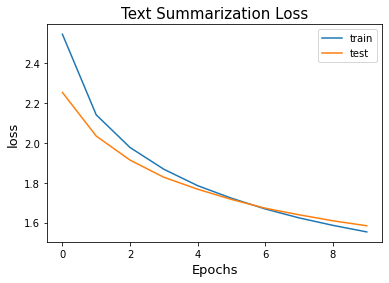

In [ ]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.xlabel('Epochs', fontsize = 13)
plt.ylabel('loss', fontsize = 13)
plt.title('Text Summarization Loss', fontsize = 15)
plt.legend()
plt.show()

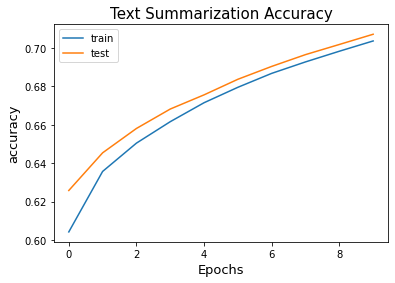

In [ ]:
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.xlabel('Epochs', fontsize = 13)
plt.ylabel('accuracy', fontsize = 13)
plt.title('Text Summarization Accuracy', fontsize = 15)
plt.legend()
plt.show()

## 3-7. 모델링 요약문 출력 테스트 진행

In [ ]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [ ]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

In [ ]:
# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)
# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

In [ ]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if(sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if(i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [ ]:
print("원문 : ",seq2text(encoder_input_test[5]))
print("실제 요약문 :",seq2summary(decoder_input_test[5]))
print("예측 요약문 :",decode_sequence(encoder_input_test[5].reshape(1, text_max_len)))
print("\n")

print("원문 : ",seq2text(encoder_input_test[11]))
print("실제 요약문 :",seq2summary(decoder_input_test[11]))
print("예측 요약문 :",decode_sequence(encoder_input_test[10].reshape(1, text_max_len)))
print("\n")

원문 :  really impressed coffee nice bold taste yet smooth finish would order coffee 
실제 요약문 : good coffee 
예측 요약문 :  good coffee


원문 :  used one pod big mug strong really good flavor 
실제 요약문 : loved this coffee 
예측 요약문 :  good coffee




In [ ]:
for i in range(0, 50):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  dogs food motivated put medicine know know always eat right around pill ugh frustrating shove throat hurts feelings hurts feeling found pill pockets dogs love actually run kitchen smell preparing smell pretty strong unsure cannot smell pills pill pockets taste good care either way fine product stress relief stress sick dog overwhelming thankful product always amazon product great price beating vet several dollars 
실제 요약문 : best thing ever invented 
예측 요약문 :  best ever


원문 :  dogs nuts dogswell happy hips dried breasts made china hardly ever give dogs wish company would manufactured elsewhere 
실제 요약문 : happy hips 
예측 요약문 :  made in china


원문 :  big ramen fan seeing pack sale picked low cost gamble chili flavor pretty horrible broth basically tastes smells like taco seasoning would buy 
실제 요약문 : meh flavor 
예측 요약문 :  not bad


원문 :  love product seller receive flavor monthly stores well good refreshing clean taste one favorites sign receive item monthly cheaper added product sell

In [ ]:
for i in range(500, 1000):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  dog owner whole life used many different brands say far best food ever purchased month old english bulldog months tell huge difference coat eating habits feces also gave brand year old great dane mix lost pounds past months way active yes food expensive worth buy nice things best friend 
실제 요약문 : love this brand 
예측 요약문 :  best dog food ever


원문 :  found great tasting water crisp clean smooth refreshing taste taste saltiness noticeable flavor larger liter bottle convenient bringing gym keep hydrated workout long day work say could tell ph electrolytes made difference like taste better average bottle water take star although good water price little high side 
실제 요약문 : clean tasting water convenient bottle size 
예측 요약문 :  refreshing


원문 :  best wheat free great price would love business thanks 
실제 요약문 : review of mi del chocolate sandwich cookies 
예측 요약문 :  best price ever


원문 :  husband grown son love power crunch peanut butter creme bars 
실제 요약문 : they love them 
예측 요약문 :  gre

In [ ]:
for i in range(300, 400):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  expecting popped one mouth nice union salty sweet light sweet yam flavor sweet potato chips strong tasting light airy still provide good crunch kind cool feeling tongue like bubbles think new chip waist certainly afford fat traditional chips anymore 
실제 요약문 : these are addictive 
예측 요약문 :  addictive


원문 :  dogs love problem crunchie enough almost choked pop oven half hour come crunchy problem trying chew fun hear crunch crunch crunch time best free shipping got order thanks bunch 
실제 요약문 : dogs love them 
예측 요약문 :  good product


원문 :  shopped around best dried cherries best still soft hard dried use bake put salads eat right bag doc trying natural treatments dark cherries supposed anti inflammatory properties 
실제 요약문 : the best dried cherries 
예측 요약문 :  best dried cherries


원문 :  favorite cereal since childhood slightly dissapointed size box obvious cereal purchased germany box small added sugar european version best get lots friends europe get real fix christmas birthday 
실제 

In [ ]:
for i in range(400, 500):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  tasting chocolate never want anything else purchase glad amazon 
실제 요약문 : the worlds best 
예측 요약문 :  chocolate raspberry chocolate


원문 :  bought cytomax fuel run went gatorade rough stomach even dilute problem cytomax full strength thicker sports drinks lot like drinking juice thought tasted great important thing able stomach long haul noticeably helpful one six mile without drink along miles crashed last miles cytomax oreos recovered ready pick pace back min 
실제 요약문 : easy on the stomach tastes great 
예측 요약문 :  great energy drink


원문 :  son gluten free casein dairy free loves pretzels tried taste good light crisp salty liked better regular old fashion style pretzels 
실제 요약문 : great pretzel and gluten free 
예측 요약문 :  great pretzels


원문 :  currently weight watchers originally saw people raving brownies message decided try amazing add fat free vanilla yogurt bake enjoy got original version added tsp mint amazing super chocolatey chewy number ways recipe liking like adding shredd

In [ ]:
for i in range(1500, 1600):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  daughter love five tasty creamy strawberry flavor top crackers think crunchier baby mum mums going buying lot 
실제 요약문 : tasty low calorie kids and adults 
예측 요약문 :  delicious and nutritious


원문 :  looking authentic thai curry made dish times liking like spicy generous portions add chili flakes little curry powder buy confidence keep pantry stocked 
실제 요약문 : fantastic 
예측 요약문 :  great soup


원문 :  love snack eat husband eats importantly year old loves replace requests snacks loves favorite part ingredient fruit purees types berries like pureed fruit put handy pouch one calories yum 
실제 요약문 : best snack ever 
예측 요약문 :  great snack for kids


원문 :  generic weak coffee espresso although beans pretty oily tastes like coffee tad bit less bitter gross folgers near espresso flavor quality local walmart stopped selling sam choice espresso beans thought would good alternative rather hand chewed buy crap 
실제 요약문 : ugh 
예측 요약문 :  bitter taste


원문 :  buy dad favorite normally buy caribou bl

In [ ]:
for i in range(50, 150):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  far favorite evening cup would discerning drinker even know decaf tully coffees always superior quality exception full bodied overpowering like french roast decafs 
실제 요약문 : my favorite decaf 
예측 요약문 :  best decaf ever


원문 :  ordered pack expected good coffee disappointed one cut packing messed coffee box throw away one honestly want try 
실제 요약문 : ll never order this again 
예측 요약문 :  not as described


원문 :  bought dog loved much dog loves eating vegetables fruits therefore chose treat instead meat treats really likes definitely buy 
실제 요약문 : great flavor and my dog loves it 
예측 요약문 :  my dog loves these


원문 :  bought try make cola drink like borders book store sells close maybe need practice making 
실제 요약문 : product makes good cola drinks 
예측 요약문 :  good stuff


원문 :  tried first time today enjoyed mild bold enough flavor could drink afternoon cup feeling sluggish bitterness smell house brewing caribou coffee normally lean towards italian french blend really like great medium 

In [ ]:
for i in range(150, 250):
    print("원문 : ",seq2text(encoder_input_test[i]))
    print("실제 요약문 :",seq2summary(decoder_input_test[i]))
    print("예측 요약문 :",decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 :  month old weimaraner allergic beef makes finding treats bit challenge luckily found zuke right away beef wheat corn small size moist texture best training good behavior tried chicken peanut butter salmon flavors salmon definitely favorite next think get rabbit flavor try 
실제 요약문 : favorite treats 
예측 요약문 :  my favorite treat


원문 :  could find bones locally since dog special diet want take chance substitute half price could get locally bought several bags offset shipping charges would buy amazon 
실제 요약문 : good deal 
예측 요약문 :  good product but


원문 :  digestives arrived perfect condition unbroken fresh imported foods tend expensive fair price love love dip tea husband likes buttered people love little jam well known brand however like eat enjoyed 
실제 요약문 : yummy biscuits 
예측 요약문 :  great


원문 :  tried flavors pods like best full flavored rich 
실제 요약문 : great coffee pods 
예측 요약문 :  best decaf


원문 :  daughter decided green mountain one favourite brands keurig coffee strong aroma bi

## 추가 필요 데이터(발표자료 만들기 위함)

In [ ]:
df_1 = pd.read_csv('Reviews.csv')
df_1

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...,...
568449,568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568450,568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568451,568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."
568452,568453,B004I613EE,A3IBEVCTXKNOH,"Kathy A. Welch ""katwel""",1,1,5,1331596800,Favorite Training and reward treat,These are the BEST treats for training and rew...


In [ ]:
df_count = df_1['UserId'].value_counts()
df_count = pd.DataFrame(df_count)
df_count

,UserId
A3OXHLG6DIBRW8,448
A1YUL9PCJR3JTY,421
AY12DBB0U420B,389
A281NPSIMI1C2R,365
A1Z54EM24Y40LL,256
...,...
A1KFVEDDNABPJA,1
A18IQMKLGKT1JJ,1
A18KO44YXO2BP7,1
A3FX71BV0L80AB,1


In [ ]:
df1_cou = df_count[df_count['UserId'] < 2]
df1_cou

,UserId
A8MZTPGN5YYQS,1
AC4M5FAVBJCL3,1
A37OKF812DRXM6,1
A6BREIUOF33U1,1
A11YQON7N0UC2R,1
...,...
A1KFVEDDNABPJA,1
A18IQMKLGKT1JJ,1
A18KO44YXO2BP7,1
A3FX71BV0L80AB,1


In [ ]:
df_count[df_count['UserId'] < 10]

,UserId
A1OITYOXXH338D,9
A129LFK27JMYB3,9
A1Q8SW109EBWFN,9
AZJ1HP7MBFC4W,9
A105BOR5D5S7CJ,9
...,...
A1KFVEDDNABPJA,1
A18IQMKLGKT1JJ,1
A18KO44YXO2BP7,1
A3FX71BV0L80AB,1


In [ ]:
len(df1_cou)/len(df_count)

0.6849632311303254

In [ ]:
len(df_count[df_count['UserId'] < 5])/len(df_count)

0.9078610788919741

In [ ]:
df_count[df_count['UserId'] < 10].sum()

UserId    427160
dtype: int64

In [ ]:
len(df_1) - df_count[df_count['UserId'] < 10].sum()

UserId    141294
dtype: int64

In [ ]:
df_count[df_count['UserId'] > 5].sum() /len(df_count[df_count['UserId'] > 5])

UserId    11.929027
dtype: float64

/Users/jaehyeonglee/opt/anaconda3/envs/P41_NLP/lib/python3.7/site-packages/ipykernel_launcher.py:4: MatplotlibDeprecationWarning: Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.
  after removing the cwd from sys.path.


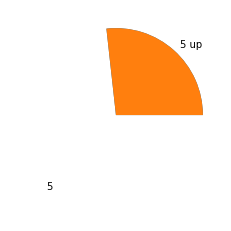

In [ ]:
ratio = [df_count[df_count['UserId'] < 5].sum(), len(df_count) - df_count[df_count['UserId'] < 5].sum()]
labels = ['5', '5 up']

plt.pie(ratio, labels = labels)
plt.show();

In [ ]:
df_count

,UserId
A3OXHLG6DIBRW8,448
A1YUL9PCJR3JTY,421
AY12DBB0U420B,389
A281NPSIMI1C2R,365
A1Z54EM24Y40LL,256
...,...
A1KFVEDDNABPJA,1
A18IQMKLGKT1JJ,1
A18KO44YXO2BP7,1
A3FX71BV0L80AB,1


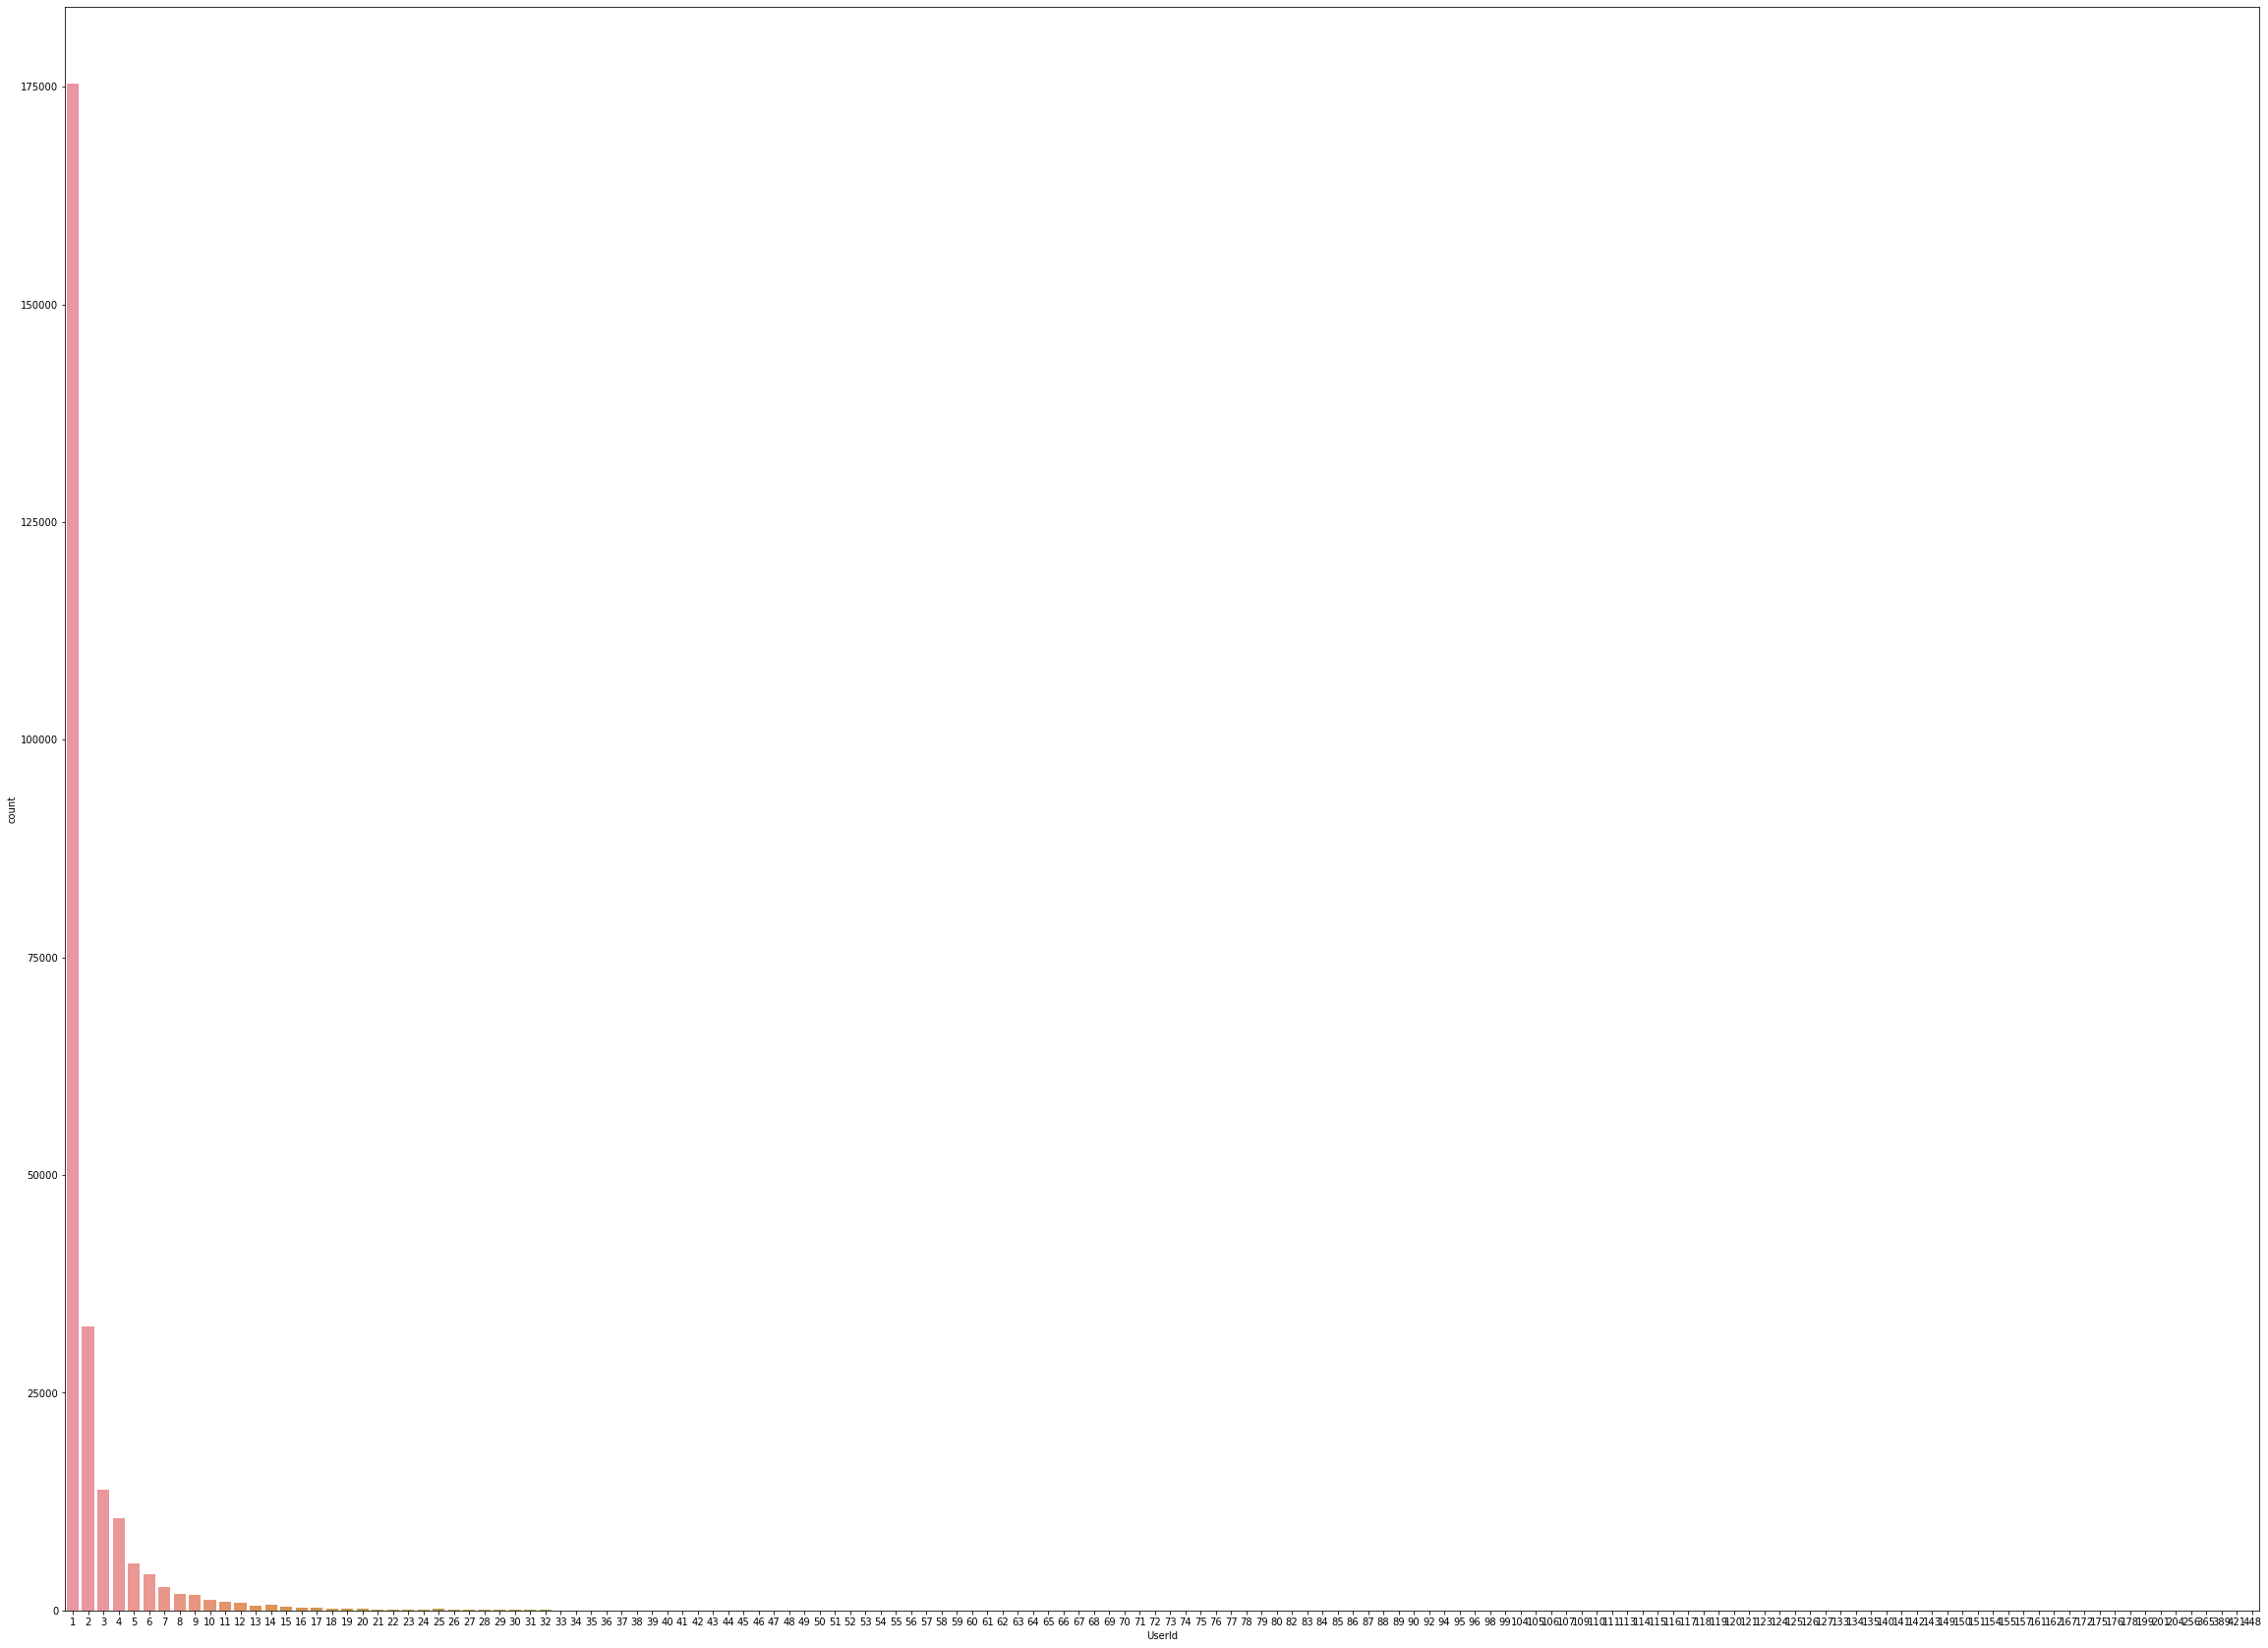

In [ ]:
plt.figure(figsize = (40,30))
sns.countplot(x = 'UserId', data = df_count)

In [ ]:
ax = df_count[df_count['UserId'] > 2].sum()[0] / len(df_count[df_count['UserId'] > 2])

Text(0.5, 1.0, 'Buy')

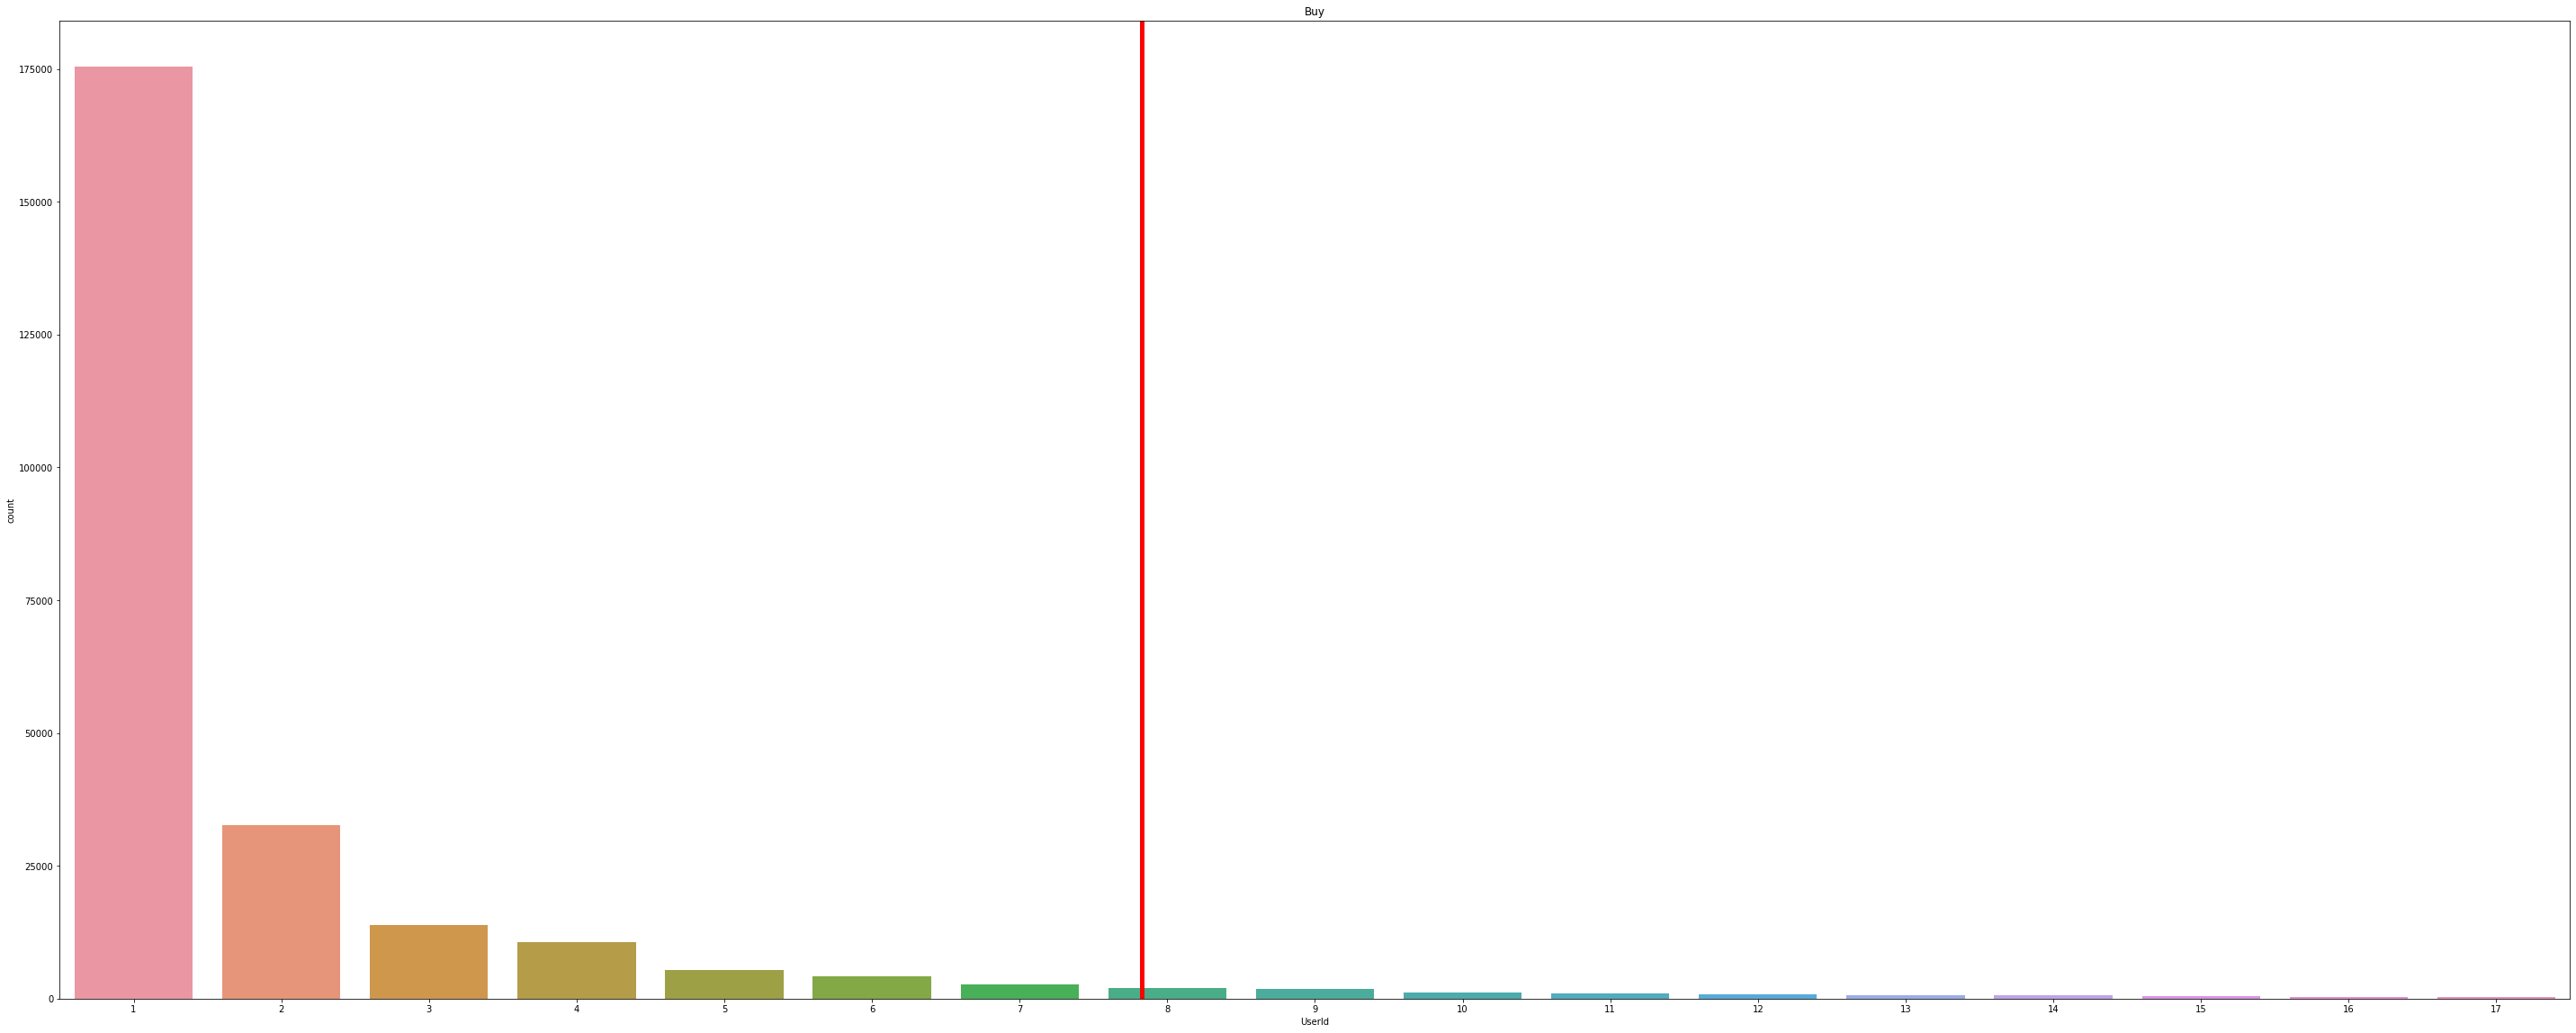

In [ ]:

plt.figure(figsize = (50,20))
sns.countplot(x = 'UserId', data = df_count[df_count['UserId'] < 18])
plt.axvline(ax, color='red', linewidth=5)
plt.title('Buy')

In [ ]:
len(df_count[df_count['UserId'] > 5])

18176

In [ ]:
ax

6.826640283274318

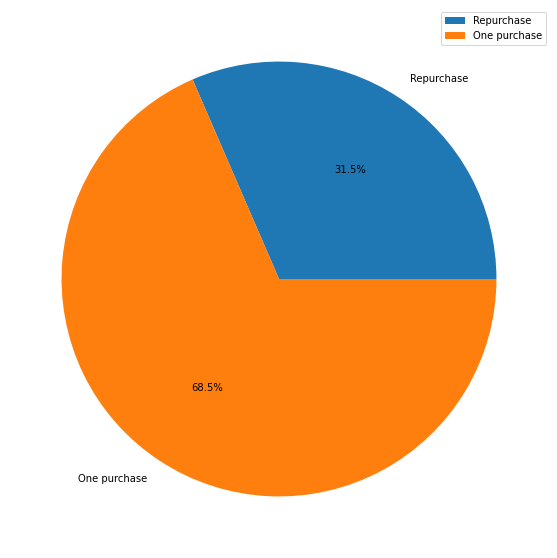

In [ ]:
x1 = [len(df_count[df_count['UserId'] > 1]), len(df_count[df_count['UserId'] == 1])]
x2 = ['Repurchase', 'One purchase']
plt.figure(figsize = (20,10))
plt.pie(x1, labels = x2,  autopct='%.1f%%')
plt.legend()
plt.show();

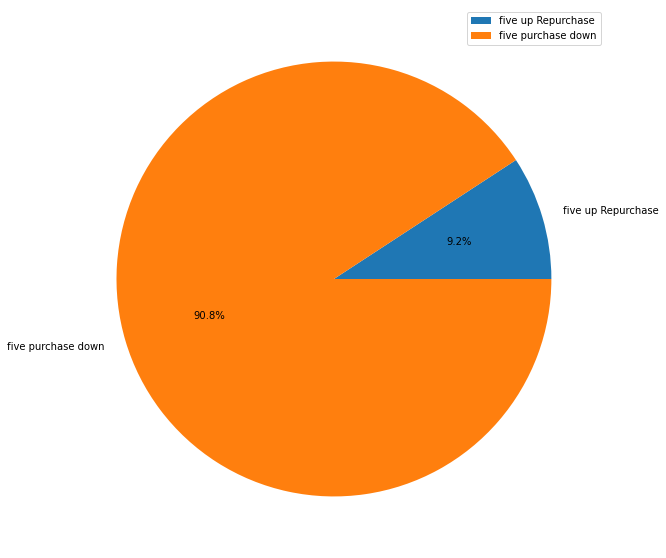

In [ ]:
x1 = [len(df_count[df_count['UserId'] > 4]), len(df_count[df_count['UserId']  < 5])]
x2 = ['five up Repurchase', 'five purchase down']
plt.figure(figsize = (20,10))
plt.pie(x1, labels = x2,  autopct='%.1f%%')
plt.legend()
plt.show();

## 전체 리뷰 중에서 1회 고객님과 재구매 고객님의 비율이 3:7로 보여짐.
## 실질적으로, 일회성 고객님이 많기 때문에 이 고객님들을 조금이라도 재구매 고객님으로 만들 수 있다면 회사의 수익에 긍정적인 영향을 끼칠 수 있음
## 재구매 고객님의 평균 구매량은 약 7~8개로 이어질 수 있기 때문에, 재구매 고객으로 전환만 한다면 현재 매출의 몇배 이상이 나올 수 있다고 판단함.